In [1]:
import os
import sys

# Add project root to PYTHONPATH automatically
PROJECT_ROOT = r"C:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\find_issues.ipynb"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from src.model_pipelines.dl_pipeline import train_model, evaluate, predict
from src.utils.model_evaluation import evaluate_and_plot_block
from src.utils.hist_baseline import historical_baseline_multi
from src.utils.preprocessing import cyclical_encode, scale_features, encode_detectors
from src.utils.sequences import create_nhits_sequences, NHitsDataset
from src.utils.plots import plot_training_curves
from src.model_pipelines.losses import (
    SpikeWeightedMSELoss,
    TwoTermSpikeLoss,
    DeltaLoss,
    LossConfig,
    create_loss
)

from src.utils.crafted_features import (
    SpikeFeatureConfig,
    add_spike_features,
    add_delta_features,
    add_rolling_stats,
    add_spike_labels,
    add_lags_and_drop
)


from src.models.mlp_forecaster import MLPForecaster
from src.models.n_hits import NHitsForecaster
from src.models.tcn_forecaster import TCNForecaster
from src.models.transformer_forecaster import TransformerForecaster

FILE_PATH = "prepared_data/preprocessed_full_data.csv"

In [2]:
def run_dl_experiment(
    model,
    optimizer,
    criterion,
    X_train_hist,
    Y_train,
    train_det_idx,
    X_val_hist,
    Y_val,
    val_det_idx,
    X_test_hist,
    Y_test,
    test_det_idx,
    device="cuda",
    batch_size=128,
    epochs=10,
    grad_clip=1.0,
    scheduler=None,
    scaler=None,
    exp_name="",
    patience=None,
):
    """
    Runs the full deep-learning training pipeline.

    - Builds model + dataloaders
    - Trains the model
    - Returns model, predictions, losses
    """

    # -------------------------
    # DATALOADERS
    # -------------------------
    train_loader = DataLoader(
        NHitsDataset(X_train_hist, Y_train, train_det_idx),
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True
    )

    val_loader = DataLoader(
        NHitsDataset(X_val_hist, Y_val, val_det_idx),
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )

    if X_test_hist is None or Y_test is None or test_det_idx is None:
        test_loader = None
    else:
        test_loader = DataLoader(
            NHitsDataset(X_test_hist, Y_test, test_det_idx),
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
        )

    model.to(device)

    # -------------------------
    # TRAINING
    # -------------------------
    train_losses, val_losses, best_state = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        num_epochs=epochs,
        grad_clip=grad_clip,
        patience=patience,
    )

    # Save losses to file
    os.makedirs(f"plots_training_dl/{broad_exp_name}/", exist_ok=True)
    with open(f"plots_training_dl/{broad_exp_name}/losses_{exp_name}.txt", "w") as f:
        f.write("epoch,train_loss,val_loss\n")
        for i, (t_loss, v_loss) in enumerate(zip(train_losses, val_losses)):
            f.write(f"{i+1},{t_loss:.6f},{v_loss:.6f}\n")

    plot_training_curves(train_losses, val_losses, filename=f"training_curve{exp_name}.png", dir = f"plots_training_dl/{broad_exp_name}/")
    #model.load_state_dict(best_state)
    if test_loader is not None:
        _, test_loss = evaluate(model, test_loader, criterion, device)
        print(f"Test Loss ({exp_name}): {test_loss:.4f}")

    return model, train_losses, val_losses

In [3]:
def prepare_eval_df(df, idx_seq, preds, horizon):
    """
    df: the dataset (train, val or test)
    idx_seq: array of starting indices returned by create_nhits_sequences
    preds: model predictions (N, horizon)
    """

    df_subset = df.loc[idx_seq].copy()
    print(df.info())
    print(df_subset.info())
    print(len(df_subset), len(idx_seq), preds.shape)

    eval_df = pd.DataFrame({
        "row_idx": idx_seq,
        "timestamp": df_subset["timestamp"].values,
        "detector_id": df_subset["detector_id"].values,
    })
    

    # Add predictions
    for h in range(1, horizon + 1):
        eval_df[f"pred_{h}h"] = preds[:, h-1].numpy()

    # Add ground truth targets
    for h in range(1, horizon + 1):
        eval_df[f"future_{h}h"] = (
            df.groupby("detector_id")["congestion_index"]
              .shift(-h)
              .loc[idx_seq]
              .values
        )

    return eval_df.dropna()

In [4]:
def prepare_dl_data(history_offsets, forecast_horizon, nb_detectors,
                    data_splits=(0.6, 0.2, 0.2)):
    
    # LOAD + BASIC FIXES
    keep_cols = [
        "timestamp", "detector_id", "congestion_index", #"year",
        "hour", "day_of_week", "month", "is_weekend", "lon", "lat",
        "is_holiday", "is_school_holiday", "is_rush_hour", "free_flow_speed",
        "temperature", "precipitation", "visibility", "is_snow", "is_fog"
    ]
    print("Loading data...")
    if not os.path.exists("prepared_data/prepared_small_data.csv") or True:
        df = pd.read_csv(FILE_PATH, usecols=keep_cols)
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df["orig_idx"] = df.index
        df = cyclical_encode(df)
        print("Data loaded and basic fixes applied.")
        
        # DETECTOR SAMPLING
        df_small = df[df["detector_id"].isin(df["detector_id"].unique()[:nb_detectors])]
        df_small = df_small.sort_values(["detector_id", "timestamp"])
        print("Detector sampling done.")
        df_small.to_csv("prepared_data/prepared_small_data.csv", index=False)
    else:
        df_small = pd.read_csv("prepared_data/prepared_small_data.csv")
        df_small["timestamp"] = pd.to_datetime(df_small["timestamp"])
        print("Small prepared data loaded from CSV.")

    print(df_small.head())
    print(df_small.info())

    
    # DETECTOR ENCODING
    df_small, det2idx = encode_detectors(df_small)

    weather_lags = [-i for i in range(1, 25, 8)]

    # CONFIG
    feature_cols_norm = [
        "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
    ]
    feature_cols = [
        "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
        "is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
        "lon", "lat", #"year",
        "temperature", "precipitation", "visibility", "is_snow", "is_fog",
        "congestion_index", "free_flow_speed"
    ] + [f"temperature_lag_{lag}h" for lag in weather_lags] \
      + [f"precipitation_lag_{lag}h" for lag in weather_lags] \
      + [f"visibility_lag_{lag}h" for lag in weather_lags]
    """feature_cols_norm = [
        "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos", "lon", "lat", "congestion_index"
    ]
    """

    # SPLIT
    train = df_small[df_small["timestamp"].dt.year <= 2019].copy()
    val = df_small[df_small["timestamp"].dt.year == 2023].copy()
    test = df_small[df_small["timestamp"].dt.year == 2024].copy()
    train = train.set_index("orig_idx")
    val   = val.set_index("orig_idx")
    test  = test.set_index("orig_idx")
    print("Data splitting done.")

    # NORMALIZATION  
    train, val, test, std_scaler, mm_scaler = scale_features(
        train, val, test, feature_cols_norm, latlon_cols=["lon", "lat"]
    )
    print("Feature scaling done.")

    # WEATHER LAGS
    if "temperature" in feature_cols_norm:
        train = add_lags_and_drop(train, weather_lags)
        val   = add_lags_and_drop(val, weather_lags)
        test  = add_lags_and_drop(test, weather_lags)
        print("Lag features created and NaNs dropped.")
    

    # BUILD ALL SEQUENCES
    X_train_hist, Y_train, idx_train, det_train = create_nhits_sequences(
        train, feature_cols, history_offsets, forecast_horizon)

    X_val_hist, Y_val, idx_val, det_val = create_nhits_sequences(
        val, feature_cols, history_offsets, forecast_horizon)

    X_test_hist, Y_test, idx_test, det_test = create_nhits_sequences(
        test, feature_cols, history_offsets, forecast_horizon)
    print("Sequence creation done.")
    
    return (X_train_hist, Y_train, idx_train, det_train,
            X_val_hist, Y_val, idx_val, det_val,
            X_test_hist, Y_test, idx_test, det_test,
            train, val, test, std_scaler, mm_scaler,
            df_small)

In [6]:
df = pd.read_csv(FILE_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["orig_idx"] = df.index
df = cyclical_encode(df)
print("Data loaded and basic fixes applied.")
        
# DETECTOR SAMPLING
df_small = df[df["detector_id"].isin(df["detector_id"].unique()[:100])]
df_small = df_small.sort_values(["detector_id", "timestamp"])

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

          mean       std  min       max
year                                   
2015  0.460760  0.166697  0.0  0.981532
2016  0.456532  0.165992  0.0  0.983878
2017  0.458097  0.167295  0.0  0.991309
2018  0.471256  0.168393  0.0  0.986977
2019  0.483354  0.165192  0.0  0.992461
2020  0.486323  0.161602  0.0  0.991090
2021  0.482414  0.167682  0.0  0.992436
2022  0.491431  0.174077  0.0  0.993146
2023  0.493788  0.176385  0.0  0.995809
2024  0.481608  0.174721  0.0  0.993146


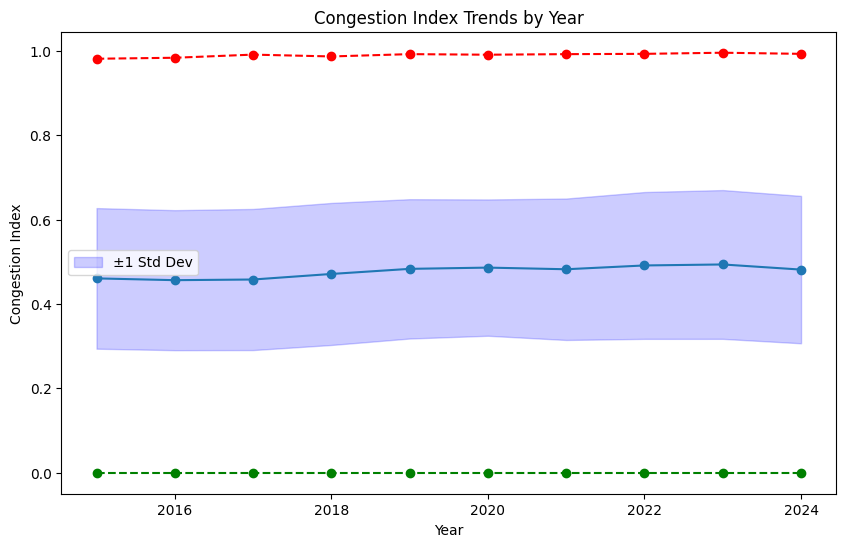

In [9]:
df_years_tendance = df_small.groupby("year")["congestion_index"] \
        .agg(["mean", "std", "min", "max"])

print(
    df_years_tendance
)

#plot
import matplotlib.pyplot as plt
# notebook plot
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(df_years_tendance.index, df_years_tendance["mean"], marker='o')
plt.plot(df_years_tendance.index, df_years_tendance["min"], marker='o', linestyle='--', color='green')
plt.plot(df_years_tendance.index, df_years_tendance["max"], marker='o', linestyle='--', color='red')
plt.fill_between(df_years_tendance.index,
                 df_years_tendance["mean"] - df_years_tendance["std"],
                 df_years_tendance["mean"] + df_years_tendance["std"],
                 color='blue', alpha=0.2, label='±1 Std Dev')
plt.legend()
plt.title("Congestion Index Trends by Year")
plt.xlabel("Year")
plt.ylabel("Congestion Index")
plt.show()

In [8]:
history_offsets = [0, 1, 2, 4] + list(range(24, 168, 24))    # 1 week of history
forecast_horizon = 24
nb_detectors = 100
evaluation_years = [2018]
dir = f"plots_training_dl/{broad_exp_name}/"

X_train_hist, Y_train, idx_train, det_train, \
X_val_hist, Y_val, idx_val, det_val, \
X_test_hist, Y_test, idx_test, det_test, \
train, val, test, std_scaler, mm_scaler, df_small = prepare_dl_data(history_offsets, forecast_horizon, nb_detectors)

Loading data...
Data loaded and basic fixes applied.
Detector sampling done.
               timestamp      detector_id  hour  day_of_week  is_weekend  \
0    2015-01-01 00:00:00  100101010000369     0            3           0   
956  2015-01-01 04:00:00  100101010000369     4            3           0   
1195 2015-01-01 05:00:00  100101010000369     5            3           0   
1659 2015-01-01 07:00:00  100101010000369     7            3           0   
1899 2015-01-01 08:00:00  100101010000369     8            3           0   

      month  is_holiday  is_rush_hour  is_school_holiday  free_flow_speed  \
0         1           0             0                  0            114.0   
956       1           0             0                  0            114.0   
1195      1           0             0                  0            114.0   
1659      1           0             1                  0            114.0   
1899      1           0             1                  0            114.0   

   

[2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]
year      2015      2016      2017      2018      2019      2020      2021  \
hour                                                                         
0     0.345121  0.336878  0.343180  0.345920  0.357756  0.356439  0.369580   
1     0.352799  0.343334  0.352578  0.354696  0.364387  0.361724  0.363498   
2     0.359073  0.348430  0.359189  0.361218  0.366995  0.371659  0.360134   
3     0.360620  0.349502  0.358965  0.359536  0.365754  0.370888  0.361200   
4     0.353135  0.341483  0.347187  0.351317  0.358347  0.362601  0.351437   
5     0.349989  0.345597  0.356319  0.352390  0.359362  0.363926  0.349577   
6     0.365447  0.360948  0.370528  0.371016  0.378445  0.383098  0.357507   
7     0.381054  0.377762  0.379396  0.389366  0.403137  0.406203  0.371641   
8     0.392197  0.392581  0.392128  0.407880  0.417032  0.412360  0.368996   
9     0.378425  0.379326  0.383366  0.396008  0.391728  0.389746  0.368042   
10    0.3817

C:\Users\adib4\AppData\Local\Temp\ipykernel_35420\3721708896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  det_df["year"] = det_df["timestamp"].dt.year


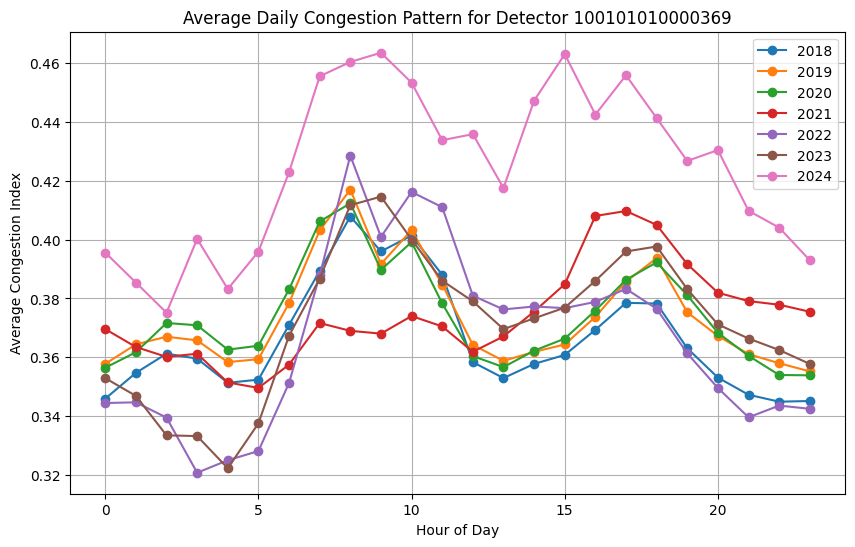

In [9]:
det = df_small["detector_id"].unique()[0]  # pick one
det_df = df_small[df_small["detector_id"] == det]
det_df["year"] = det_df["timestamp"].dt.year
print(det_df["year"].unique())

det_df_year = det_df.groupby(["year", "hour"])["congestion_index"].mean().unstack("year")

print(
    det_df.groupby(["year", "hour"])["congestion_index"]
          .mean()
          .unstack("year")
          .head(24)  # typical daily pattern
)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(2018, 2025):
    plt.plot(det_df_year.index, det_df_year[i], marker='o', label=str(i))

plt.title(f"Average Daily Congestion Pattern for Detector {det}")
plt.xlabel("Hour of Day")
plt.ylabel("Average Congestion Index")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print("Train mean/std:", train["congestion_index"].mean(), train["congestion_index"].std())
print("Val mean/std:",   val["congestion_index"].mean(), val["congestion_index"].std())
print("Test mean/std:",  test["congestion_index"].mean(), test["congestion_index"].std())


Train mean/std: -1.2923641669059056e-05 1.0000010887966786
Val mean/std: 0.16269570024538452 1.0561057929646533
Test mean/std: 0.08960271824791419 1.0458821430044833


In [5]:
def prepare_dl_data_loaded(history_offsets, forecast_horizon, nb_detectors, df_base,
                    years_split, feature_cols_norm=None, feature_cols_base=None,
                    weather_lags=None):
    
    # LOAD + BASIC FIXES
    keep_cols = [
        "timestamp", "detector_id", "congestion_index", "year",
        "hour", "day_of_week", "month", "is_weekend", "lon", "lat",
        "is_holiday", "is_school_holiday", "is_rush_hour", 
        "free_flow_speed", "season",
        "temperature", "precipitation", "visibility", "is_snow", "is_fog"
    ]
    print("Loading data...")
    df_small = df_base[df_base["detector_id"].isin(df_base["detector_id"].unique()[:nb_detectors])]
    df_small = df_small.sort_values(["detector_id", "timestamp"])
    df_small.loc[(df_small["month"] <= 2) | (df_small["month"] == 12), "season"] = 0  # winter
    df_small.loc[(df_small["month"] > 2) & (df_small["month"] <= 5), "season"] = 1   # spring
    df_small.loc[(df_small["month"] > 5) & (df_small["month"] <= 8), "season"] = 2   # summer
    df_small.loc[(df_small["month"] > 8) & (df_small["month"] <= 11), "season"] = 3  # fall
    
    # DETECTOR ENCODING
    df_small, det2idx = encode_detectors(df_small)

    if weather_lags is None: weather_lags = [-i for i in range(1, 25, 8)]

    # CONFIG
    if feature_cols_norm is None:
        feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
    if feature_cols_base is None:
        feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            #"lon", "lat", #"year",
            "temperature", "precipitation", "visibility", #"is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]
    else: feature_cols = feature_cols_base.copy()

    if "temperature" in feature_cols:
        feature_cols = feature_cols + [f"temperature_lag_{lag}h" for lag in weather_lags] \
        + [f"precipitation_lag_{lag}h" for lag in weather_lags] \
        + [f"visibility_lag_{lag}h" for lag in weather_lags]


    # SPLIT
    train = df_small[df_small["timestamp"].dt.year.isin(years_split[0])].copy()
    val = df_small[df_small["timestamp"].dt.year.isin(years_split[1])].copy()
    test = df_small[df_small["timestamp"].dt.year.isin(years_split[2])].copy()
    train = train.set_index("orig_idx")
    val   = val.set_index("orig_idx")
    test  = test.set_index("orig_idx")
    if years_split[2]==[]: test=None
    print("Data splitting done.")

    # NORMALIZATION  
    if "season" in df_small.columns and "year" in df_small.columns:
        minmax_cols = ["lon", "lat", "year", "season"]
    else:
        minmax_cols = ["lon", "lat"]
    train, val, test, std_scaler, mm_scaler = scale_features(
        train, val, test, feature_cols_norm, latlon_cols=minmax_cols
    )
    print("Feature scaling done.")

    # WEATHER LAGS
    if "temperature" in feature_cols:
        train = add_lags_and_drop(train, weather_lags)
        val   = add_lags_and_drop(val, weather_lags)
        if test is not None: test  = add_lags_and_drop(test, weather_lags)
        print("Lag features created and NaNs dropped.")
    
    print("Feature columns:", feature_cols)
    print("train features:", train[feature_cols].info())
    train = train[feature_cols+["timestamp", "detector_id", "det_index"]]
    val = val[feature_cols+["timestamp", "detector_id", "det_index"]]
    if test is not None: test = test[feature_cols+["timestamp", "detector_id", "det_index"]]
    

    # BUILD ALL SEQUENCES
    X_train_hist, Y_train, idx_train, det_train = create_nhits_sequences(
        train, feature_cols, history_offsets, forecast_horizon)

    X_val_hist, Y_val, idx_val, det_val = create_nhits_sequences(
        val, feature_cols, history_offsets, forecast_horizon)

    if test is not None:
        X_test_hist, Y_test, idx_test, det_test = create_nhits_sequences(
        test, feature_cols, history_offsets, forecast_horizon)
    else:
        X_test_hist, Y_test, idx_test, det_test = None, None, None, None
    print("Sequence creation done.")
    print(f"features: {train.columns.tolist()}")
    
    return (X_train_hist, Y_train, idx_train, det_train,
            X_val_hist, Y_val, idx_val, det_val,
            X_test_hist, Y_test, idx_test, det_test,
            train, val, test, std_scaler, mm_scaler)

In [6]:
def main(nb_detectors, forecast_horizon, history_offsets, evaluation_years, broad_exp_name, df_base):
    dir = f"plots_training_dl/{broad_exp_name}/"

    X_train_hist, Y_train, idx_train, det_train, \
    X_val_hist, Y_val, idx_val, det_val, \
    X_test_hist, Y_test, idx_test, det_test, \
    train, val, test, std_scaler, mm_scaler = prepare_dl_data_loaded(history_offsets, forecast_horizon, nb_detectors, df_base)
    
    # BASELINE
    hist_df = historical_baseline_multi(train, horizon=forecast_horizon, window_size=10)
    evaluate_and_plot_block(hist_df, horizon=forecast_horizon, years=evaluation_years, plot_years=evaluation_years, filename="_hist_baseline",
                            dir=f"{dir}/baseline", max_blocks=10)
                            
    # EXPERIMENT PARAMS
    model_1 = MLPForecaster(
        input_length=len(history_offsets),
        num_features=X_train_hist.shape[-1],
        horizon=forecast_horizon,
        num_detectors=nb_detectors,
        dropout=0,
        max_dim=1024,
        emb_dim=256
    )
    optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-4)
    params_experiment_1 = {
        "model": model_1,
        "optimizer": optimizer_1,
        "criterion": nn.MSELoss(),
        "X_train_hist": X_train_hist,
        "Y_train": Y_train,
        "train_det_idx": det_train,
        "X_val_hist": X_val_hist,
        "Y_val": Y_val,
        "val_det_idx": det_val,
        "X_test_hist": X_test_hist,
        "Y_test": Y_test,
        "test_det_idx": det_test,
        "device": "cuda",
        "batch_size": 512,
        "epochs": 15,
        "grad_clip": None,
        "scheduler": None
    }

    model_2 = NHitsForecaster(
        input_length=len(history_offsets),
        num_features=X_train_hist.shape[-1],
        horizon=forecast_horizon,
        num_detectors=nb_detectors,
        emb_dim=256,
        n_blocks=6,
        hidden_dim=512
    )
    params_experiment_2 = params_experiment_1.copy()
    params_experiment_2["model"] = model_2
    params_experiment_2["criterion"] = nn.MSELoss()
    params_experiment_2["optimizer"] = torch.optim.Adam(model_2.parameters(), lr=1e-4)
    
    # RUN EXPERIMENTS
    exp_name_1 = "MLP_Forecaster"
    exp_name_2 = "NHits_Forecaster"
    
    """model, train_losses, val_losses = run_dl_experiment(**params_experiment_1, exp_name=exp_name_1)
    eval_df = prepare_eval_df(train, idx_train, predict(model, X_train_hist, det_train), forecast_horizon)
    evaluate_and_plot_block(eval_df, horizon=forecast_horizon, years=evaluation_years, filename=exp_name_1,
                            dir=dir, max_blocks=20)"""

    model, train_losses, val_losses = run_dl_experiment(**params_experiment_2, exp_name=exp_name_2)
    eval_df = prepare_eval_df(train, idx_train, predict(model, X_train_hist, det_train), forecast_horizon)
    evaluate_and_plot_block(eval_df, horizon=forecast_horizon, years=evaluation_years, plot_years=evaluation_years, filename=exp_name_2,
                            dir=dir, max_blocks=10)


In [7]:
df_base = pd.read_csv(FILE_PATH)
df_base["timestamp"] = pd.to_datetime(df_base["timestamp"])
df_base["orig_idx"] = df_base.index
df_base = cyclical_encode(df_base)

In [ ]:
history_offsets = [0, 1, 2, 4] #+ list(range(24, 168, 24))    # 1 week of history
forecast_horizon = 1
nb_detectors = 20
broad_exp_name = "debug_trainings_higher_emb_dim-1h_forecast_20detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)


Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.16466680877131293 RMSE: 0.25797434378080336
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: nan
=== Block Forecast Evaluation ===
MAE: 0.1647
RMSE: 0.2580
Corr: nan
1084445 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48029 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
36 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)
Validating: 100%|██████████| 597/597 [00:05<00:00, 104.52it/s]


Epoch 1/10 - Train Loss: 0.0104 - Val Loss: 0.0017


Validating: 100%|██████████| 597/597 [00:05<00:00, 107.63it/s]


Epoch 2/10 - Train Loss: 0.0025 - Val Loss: 0.0019


Validating: 100%|██████████| 597/597 [00:01<00:00, 315.74it/s]


Epoch 3/10 - Train Loss: 0.0018 - Val Loss: 0.0016


Validating: 100%|██████████| 597/597 [00:05<00:00, 111.76it/s]


Epoch 4/10 - Train Loss: 0.0015 - Val Loss: 0.0009


Validating: 100%|██████████| 597/597 [00:05<00:00, 110.23it/s]


Epoch 5/10 - Train Loss: 0.0013 - Val Loss: 0.0010


Validating: 100%|██████████| 597/597 [00:02<00:00, 287.14it/s]


Epoch 6/10 - Train Loss: 0.0011 - Val Loss: 0.0010


Validating: 100%|██████████| 597/597 [00:05<00:00, 116.93it/s]


Epoch 7/10 - Train Loss: 0.0010 - Val Loss: 0.0005


Validating: 100%|██████████| 597/597 [00:05<00:00, 112.37it/s]


Epoch 8/10 - Train Loss: 0.0010 - Val Loss: 0.0004


Validating: 100%|██████████| 597/597 [00:05<00:00, 116.55it/s]


Epoch 9/10 - Train Loss: 0.0009 - Val Loss: 0.0008


Validating: 100%|██████████| 597/597 [00:04<00:00, 120.71it/s]


Epoch 10/10 - Train Loss: 0.0008 - Val Loss: 0.0004


Evaluating: 100%|██████████| 573/573 [00:05<00:00, 103.80it/s]


Test Loss (MLP_Forecaster): 0.0004
<class 'pandas.core.frame.DataFrame'>
Index: 1084465 entries, 4999466 to 23382697
Data columns (total 54 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   timestamp               1084465 non-null  datetime64[ns]
 1   detector_id             1084465 non-null  int64         
 2   hour                    1084465 non-null  int64         
 3   quality                 1084465 non-null  float64       
 4   veh_total               1084465 non-null  int64         
 5   speed_total             1084465 non-null  float64       
 6   veh_cars                1084465 non-null  int64         
 7   speed_cars              1084465 non-null  float64       
 8   veh_trucks              1084465 non-null  int64         
 9   speed_trucks            1084465 non-null  float64       
 10  year                    1084465 non-null  int64         
 11  day_of_week             1084465 non-nul

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)
Validating: 100%|██████████| 597/597 [00:04<00:00, 131.19it/s]


Epoch 1/10 - Train Loss: 0.0076 - Val Loss: 0.0008


Validating: 100%|██████████| 597/597 [00:05<00:00, 105.93it/s]


Epoch 2/10 - Train Loss: 0.0005 - Val Loss: 0.0001


Validating: 100%|██████████| 597/597 [00:05<00:00, 106.51it/s]


Epoch 3/10 - Train Loss: 0.0003 - Val Loss: 0.0006


Validating: 100%|██████████| 597/597 [00:05<00:00, 113.37it/s]


Epoch 4/10 - Train Loss: 0.0002 - Val Loss: 0.0002


Validating: 100%|██████████| 597/597 [00:05<00:00, 106.06it/s]


Epoch 5/10 - Train Loss: 0.0001 - Val Loss: 0.0000


Validating: 100%|██████████| 597/597 [00:01<00:00, 301.35it/s]


Epoch 6/10 - Train Loss: 0.0001 - Val Loss: 0.0002


Validating: 100%|██████████| 597/597 [00:02<00:00, 272.99it/s]


Epoch 7/10 - Train Loss: 0.0001 - Val Loss: 0.0001


Validating: 100%|██████████| 597/597 [00:02<00:00, 247.81it/s]


Epoch 8/10 - Train Loss: 0.0001 - Val Loss: 0.0000


Validating: 100%|██████████| 597/597 [00:02<00:00, 237.78it/s]


Epoch 9/10 - Train Loss: 0.0001 - Val Loss: 0.0000


Validating: 100%|██████████| 597/597 [00:02<00:00, 277.19it/s]


Epoch 10/10 - Train Loss: 0.0001 - Val Loss: 0.0000


Evaluating: 100%|██████████| 573/573 [00:02<00:00, 241.19it/s]


Test Loss (NHits_Forecaster): 0.0000
<class 'pandas.core.frame.DataFrame'>
Index: 1084465 entries, 4999466 to 23382697
Data columns (total 54 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   timestamp               1084465 non-null  datetime64[ns]
 1   detector_id             1084465 non-null  int64         
 2   hour                    1084465 non-null  int64         
 3   quality                 1084465 non-null  float64       
 4   veh_total               1084465 non-null  int64         
 5   speed_total             1084465 non-null  float64       
 6   veh_cars                1084465 non-null  int64         
 7   speed_cars              1084465 non-null  float64       
 8   veh_trucks              1084465 non-null  int64         
 9   speed_trucks            1084465 non-null  float64       
 10  year                    1084465 non-null  int64         
 11  day_of_week             1084465 non-n

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


In [21]:
history_offsets = [0, 1, 2, 4] #+ list(range(24, 168, 24))    # 1 week of history
forecast_horizon = 1
nb_detectors = 50
broad_exp_name = "debug_trainings_higher_emb_dim-1h_forecast_50detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)
nb_detectors = 100
broad_exp_name = "debug_trainings_higher_emb_dim-1h_forecast_100detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)
nb_detectors = 150
broad_exp_name = "debug_trainings_higher_emb_dim-1h_forecast_150detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)
nb_detectors = 200
broad_exp_name = "debug_trainings_higher_emb_dim-1h_forecast_200detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)



Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.18465006712068233 RMSE: 0.29044256682795005
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: nan
=== Block Forecast Evaluation ===
MAE: 0.1847
RMSE: 0.2904
Corr: nan
2537421 total blocks in dataframe


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48029 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
338 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...


Validating: 100%|██████████| 1473/1473 [00:06<00:00, 227.78it/s]


Epoch 1/10 - Train Loss: 0.0042 - Val Loss: 0.0002


Validating: 100%|██████████| 1473/1473 [00:05<00:00, 287.40it/s]


Epoch 2/10 - Train Loss: 0.0002 - Val Loss: 0.0001


Validating: 100%|██████████| 1473/1473 [00:05<00:00, 294.38it/s]


Epoch 3/10 - Train Loss: 0.0001 - Val Loss: 0.0001


Validating: 100%|██████████| 1473/1473 [00:05<00:00, 287.03it/s]


Epoch 4/10 - Train Loss: 0.0001 - Val Loss: 0.0000


Validating: 100%|██████████| 1473/1473 [00:05<00:00, 254.99it/s]


Epoch 5/10 - Train Loss: 0.0001 - Val Loss: 0.0001


Validating: 100%|██████████| 1473/1473 [00:05<00:00, 267.88it/s]


Epoch 6/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 1473/1473 [00:04<00:00, 296.66it/s]


Epoch 7/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 1473/1473 [00:04<00:00, 304.43it/s]


Epoch 8/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 1473/1473 [00:05<00:00, 289.02it/s]


Epoch 9/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 1473/1473 [00:05<00:00, 290.42it/s]


Epoch 10/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Evaluating: 100%|██████████| 1409/1409 [00:05<00:00, 235.82it/s]


Test Loss (NHits_Forecaster): 0.0000
<class 'pandas.core.frame.DataFrame'>
Index: 2537471 entries, 4999466 to 23292261
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_scho

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.21517492694790322 RMSE: 0.3339191641152178
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: nan
=== Block Forecast Evaluation ===
MAE: 0.2152
RMSE: 0.3339
Corr: nan


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


4941788 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48029 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
310 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...


Validating: 100%|██████████| 2910/2910 [00:11<00:00, 251.79it/s]


Epoch 1/10 - Train Loss: 0.0027 - Val Loss: 0.0001


Validating: 100%|██████████| 2910/2910 [00:11<00:00, 257.86it/s]


Epoch 2/10 - Train Loss: 0.0001 - Val Loss: 0.0001


Validating: 100%|██████████| 2910/2910 [00:10<00:00, 281.97it/s]


Epoch 3/10 - Train Loss: 0.0001 - Val Loss: 0.0001


Validating: 100%|██████████| 2910/2910 [00:10<00:00, 279.17it/s]


Epoch 4/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 2910/2910 [00:12<00:00, 238.09it/s]


Epoch 5/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 2910/2910 [00:10<00:00, 282.32it/s]


Epoch 6/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 2910/2910 [00:11<00:00, 254.76it/s]


Epoch 7/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 2910/2910 [00:10<00:00, 274.85it/s]


Epoch 8/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 2910/2910 [00:11<00:00, 257.57it/s]


Epoch 9/10 - Train Loss: 0.0000 - Val Loss: 0.0001


Validating: 100%|██████████| 2910/2910 [00:12<00:00, 233.50it/s]


Epoch 10/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Evaluating: 100%|██████████| 2794/2794 [00:13<00:00, 207.66it/s]


Test Loss (NHits_Forecaster): 0.0000
<class 'pandas.core.frame.DataFrame'>
Index: 4941888 entries, 4999466 to 23382733
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_scho

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48025 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
393 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.20639657949905788 RMSE: 0.3255698815530281
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


Correlation: nan
=== Block Forecast Evaluation ===
MAE: 0.2064
RMSE: 0.3256
Corr: nan
7430142 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48029 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
232 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...


Validating: 100%|██████████| 4360/4360 [00:17<00:00, 249.64it/s]


Epoch 1/10 - Train Loss: 0.0020 - Val Loss: 0.0002


Validating: 100%|██████████| 4360/4360 [00:17<00:00, 243.24it/s]


Epoch 2/10 - Train Loss: 0.0001 - Val Loss: 0.0001


Validating: 100%|██████████| 4360/4360 [00:18<00:00, 239.01it/s]


Epoch 3/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 4360/4360 [00:18<00:00, 232.40it/s]


Epoch 4/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 4360/4360 [00:17<00:00, 245.68it/s]


Epoch 5/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 4360/4360 [00:17<00:00, 242.83it/s]


Epoch 6/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 4360/4360 [00:19<00:00, 224.53it/s]


Epoch 7/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 4360/4360 [00:19<00:00, 227.38it/s]


Epoch 8/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 4360/4360 [00:17<00:00, 247.55it/s]


Epoch 9/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 4360/4360 [00:17<00:00, 245.99it/s]


Epoch 10/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Evaluating: 100%|██████████| 4198/4198 [00:20<00:00, 203.70it/s]


Test Loss (NHits_Forecaster): 0.0000
<class 'pandas.core.frame.DataFrame'>
Index: 7430292 entries, 4999466 to 22826054
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_scho

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


Correlation: nan
=== Block Forecast Evaluation ===
MAE: 0.2066
RMSE: 0.3256
Corr: nan
7429542 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48025 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
273 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.20590989169675908 RMSE: 0.3266591784397785
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: nan
=== Block Forecast Evaluation ===
MAE: 0.2059
RMSE: 0.3267
Corr: nan


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


10031086 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48029 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
61 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...


Validating: 100%|██████████| 5828/5828 [00:24<00:00, 238.27it/s]


Epoch 1/10 - Train Loss: 0.0015 - Val Loss: 0.0003


Validating: 100%|██████████| 5828/5828 [00:23<00:00, 244.19it/s]


Epoch 2/10 - Train Loss: 0.0001 - Val Loss: 0.0001


Validating: 100%|██████████| 5828/5828 [00:25<00:00, 225.45it/s]


Epoch 3/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 5828/5828 [00:24<00:00, 234.91it/s]


Epoch 4/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 5828/5828 [00:24<00:00, 236.74it/s]


Epoch 5/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 5828/5828 [00:24<00:00, 233.65it/s]


Epoch 6/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 5828/5828 [00:25<00:00, 233.01it/s]


Epoch 7/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 5828/5828 [00:24<00:00, 239.84it/s]


Epoch 8/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 5828/5828 [00:25<00:00, 229.09it/s]


Epoch 9/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Validating: 100%|██████████| 5828/5828 [00:23<00:00, 247.26it/s]


Epoch 10/10 - Train Loss: 0.0000 - Val Loss: 0.0000


Evaluating: 100%|██████████| 5614/5614 [00:26<00:00, 215.33it/s]


Test Loss (NHits_Forecaster): 0.0000
<class 'pandas.core.frame.DataFrame'>
Index: 10031286 entries, 4999466 to 23382787
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_sch

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48025 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
64 blocks after sampling
True columns: ['future_1h']
Predicted columns: ['pred_1h']
Plotting...


In [23]:
nb_detectors = 100

forecast_horizon = 4
broad_exp_name = "debug_trainings_higher_emb_dim-4h_forecast_100detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)

forecast_horizon = 8
broad_exp_name = "debug_trainings_higher_emb_dim-8h_forecast_100detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)

forecast_horizon = 16
broad_exp_name = "debug_trainings_higher_emb_dim-16h_forecast_100detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)

forecast_horizon = 24
broad_exp_name = "debug_trainings_higher_emb_dim-24h_forecast_100detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)

Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.29749934839931486 RMSE: 0.46037193478161603
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: nan
=== Block Forecast Evaluation ===
MAE: 0.2975
RMSE: 0.4604
Corr: nan


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:34: RuntimeWarning: Mean of empty slice
  corr = np.nanmean(corr_per_block)


4941488 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48026 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
12 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h']
Plotting...


Validating: 100%|██████████| 2909/2909 [00:11<00:00, 255.92it/s]


Epoch 1/20 - Train Loss: 0.0812 - Val Loss: 0.0717


Validating: 100%|██████████| 2909/2909 [00:10<00:00, 266.47it/s]


Epoch 2/20 - Train Loss: 0.0726 - Val Loss: 0.0681


Validating: 100%|██████████| 2909/2909 [00:13<00:00, 221.17it/s]


Epoch 3/20 - Train Loss: 0.0703 - Val Loss: 0.0685


Validating: 100%|██████████| 2909/2909 [00:12<00:00, 232.36it/s]


Epoch 4/20 - Train Loss: 0.0689 - Val Loss: 0.0660


Validating: 100%|██████████| 2909/2909 [00:11<00:00, 262.77it/s]


Epoch 5/20 - Train Loss: 0.0679 - Val Loss: 0.0680


Validating: 100%|██████████| 2909/2909 [00:10<00:00, 266.94it/s]


Epoch 6/20 - Train Loss: 0.0671 - Val Loss: 0.0693


Validating: 100%|██████████| 2909/2909 [00:10<00:00, 271.45it/s]


Epoch 7/20 - Train Loss: 0.0663 - Val Loss: 0.0693


Validating: 100%|██████████| 2909/2909 [00:11<00:00, 262.41it/s]


Epoch 8/20 - Train Loss: 0.0657 - Val Loss: 0.0672


Validating: 100%|██████████| 2909/2909 [00:12<00:00, 229.30it/s]


Epoch 9/20 - Train Loss: 0.0652 - Val Loss: 0.0674


Validating: 100%|██████████| 2909/2909 [00:12<00:00, 235.90it/s]


Epoch 10/20 - Train Loss: 0.0647 - Val Loss: 0.0697


Validating: 100%|██████████| 2909/2909 [00:12<00:00, 239.90it/s]


Epoch 11/20 - Train Loss: 0.0643 - Val Loss: 0.0666


Validating: 100%|██████████| 2909/2909 [00:10<00:00, 267.78it/s]


Epoch 12/20 - Train Loss: 0.0639 - Val Loss: 0.0656


Validating: 100%|██████████| 2909/2909 [00:12<00:00, 237.65it/s]


Epoch 13/20 - Train Loss: 0.0635 - Val Loss: 0.0676


Validating: 100%|██████████| 2909/2909 [00:11<00:00, 253.84it/s]


Epoch 14/20 - Train Loss: 0.0632 - Val Loss: 0.0663


Validating: 100%|██████████| 2909/2909 [00:10<00:00, 269.42it/s]


Epoch 15/20 - Train Loss: 0.0629 - Val Loss: 0.0679


Validating: 100%|██████████| 2909/2909 [00:10<00:00, 281.91it/s]


Epoch 16/20 - Train Loss: 0.0626 - Val Loss: 0.0697


Validating: 100%|██████████| 2909/2909 [00:10<00:00, 266.05it/s]


Epoch 17/20 - Train Loss: 0.0624 - Val Loss: 0.0683


Validating: 100%|██████████| 2909/2909 [00:12<00:00, 231.73it/s]


Epoch 18/20 - Train Loss: 0.0622 - Val Loss: 0.0680


Validating: 100%|██████████| 2909/2909 [00:11<00:00, 262.34it/s]


Epoch 19/20 - Train Loss: 0.0620 - Val Loss: 0.0674


Validating: 100%|██████████| 2909/2909 [00:12<00:00, 238.12it/s]


Epoch 20/20 - Train Loss: 0.0618 - Val Loss: 0.0692


Evaluating: 100%|██████████| 2793/2793 [00:13<00:00, 207.62it/s]


Test Loss (NHits_Forecaster): 0.0590
<class 'pandas.core.frame.DataFrame'>
Index: 4941888 entries, 4999466 to 23382733
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_scho

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48022 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
106 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h']
Plotting...
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.35992050003244996 RMSE: 0.5427484012556845
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: 0.00028892089694626717
=== Block Forecast Evaluation ===
MAE: 0.3599
RMSE: 0.5427
Corr: 0.0003


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


4941088 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48022 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
19 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h']
Plotting...


Validating: 100%|██████████| 2907/2907 [00:12<00:00, 232.93it/s]


Epoch 1/20 - Train Loss: 0.1084 - Val Loss: 0.1020


Validating: 100%|██████████| 2907/2907 [00:12<00:00, 237.41it/s]


Epoch 2/20 - Train Loss: 0.0971 - Val Loss: 0.0962


Validating: 100%|██████████| 2907/2907 [00:11<00:00, 259.20it/s]


Epoch 3/20 - Train Loss: 0.0938 - Val Loss: 0.0971


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 284.36it/s]


Epoch 4/20 - Train Loss: 0.0917 - Val Loss: 0.0963


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 280.11it/s]


Epoch 5/20 - Train Loss: 0.0901 - Val Loss: 0.0957


Validating: 100%|██████████| 2907/2907 [00:11<00:00, 250.60it/s]


Epoch 6/20 - Train Loss: 0.0888 - Val Loss: 0.0964


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 267.14it/s]


Epoch 7/20 - Train Loss: 0.0878 - Val Loss: 0.0977


Validating: 100%|██████████| 2907/2907 [00:11<00:00, 259.88it/s]


Epoch 8/20 - Train Loss: 0.0868 - Val Loss: 0.0950


Validating: 100%|██████████| 2907/2907 [00:12<00:00, 240.24it/s]


Epoch 9/20 - Train Loss: 0.0861 - Val Loss: 0.0966


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 265.30it/s]


Epoch 10/20 - Train Loss: 0.0853 - Val Loss: 0.0968


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 285.46it/s]


Epoch 11/20 - Train Loss: 0.0847 - Val Loss: 0.0969


Validating: 100%|██████████| 2907/2907 [00:12<00:00, 233.13it/s]


Epoch 12/20 - Train Loss: 0.0841 - Val Loss: 0.0959


Validating: 100%|██████████| 2907/2907 [00:11<00:00, 257.98it/s]


Epoch 13/20 - Train Loss: 0.0836 - Val Loss: 0.0963


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 284.01it/s]


Epoch 14/20 - Train Loss: 0.0831 - Val Loss: 0.0975


Validating: 100%|██████████| 2907/2907 [00:11<00:00, 261.92it/s]


Epoch 15/20 - Train Loss: 0.0827 - Val Loss: 0.0966


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 279.96it/s]


Epoch 16/20 - Train Loss: 0.0823 - Val Loss: 0.0970


Validating: 100%|██████████| 2907/2907 [00:11<00:00, 260.74it/s]


Epoch 17/20 - Train Loss: 0.0820 - Val Loss: 0.0966


Validating: 100%|██████████| 2907/2907 [00:11<00:00, 242.30it/s]


Epoch 18/20 - Train Loss: 0.0817 - Val Loss: 0.0962


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 270.76it/s]


Epoch 19/20 - Train Loss: 0.0814 - Val Loss: 0.0983


Validating: 100%|██████████| 2907/2907 [00:10<00:00, 266.51it/s]


Epoch 20/20 - Train Loss: 0.0812 - Val Loss: 0.0972


Evaluating: 100%|██████████| 2792/2792 [00:13<00:00, 205.28it/s]


Test Loss (NHits_Forecaster): 0.0821
<class 'pandas.core.frame.DataFrame'>
Index: 4941888 entries, 4999466 to 23382733
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_scho

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48018 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
25 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h']
Plotting...
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.41036550718958975 RMSE: 0.6049827456110156
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: 5.356789701998184e-05
=== Block Forecast Evaluation ===
MAE: 0.4104
RMSE: 0.6050
Corr: 0.0001


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


4940288 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48014 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
9 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h', 'future_9h', 'future_10h', 'future_11h', 'future_12h', 'future_13h', 'future_14h', 'future_15h', 'future_16h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h', 'pred_9h', 'pred_10h', 'pred_11h', 'pred_12h', 'pred_13h', 'pred_14h', 'pred_15h', 'pred_16h']
Plotting...


Validating: 100%|██████████| 2904/2904 [00:12<00:00, 231.70it/s]


Epoch 1/20 - Train Loss: 0.1277 - Val Loss: 0.1221


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 261.96it/s]


Epoch 2/20 - Train Loss: 0.1149 - Val Loss: 0.1207


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 263.25it/s]


Epoch 3/20 - Train Loss: 0.1109 - Val Loss: 0.1183


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 252.95it/s]


Epoch 4/20 - Train Loss: 0.1084 - Val Loss: 0.1173


Validating: 100%|██████████| 2904/2904 [00:10<00:00, 269.68it/s]


Epoch 5/20 - Train Loss: 0.1065 - Val Loss: 0.1169


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 245.89it/s]


Epoch 6/20 - Train Loss: 0.1050 - Val Loss: 0.1180


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 257.02it/s]


Epoch 7/20 - Train Loss: 0.1036 - Val Loss: 0.1190


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 253.21it/s]


Epoch 8/20 - Train Loss: 0.1026 - Val Loss: 0.1182


Validating: 100%|██████████| 2904/2904 [00:10<00:00, 266.57it/s]


Epoch 9/20 - Train Loss: 0.1016 - Val Loss: 0.1173


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 263.74it/s]


Epoch 10/20 - Train Loss: 0.1008 - Val Loss: 0.1189


Validating: 100%|██████████| 2904/2904 [00:12<00:00, 240.96it/s]


Epoch 11/20 - Train Loss: 0.1001 - Val Loss: 0.1178


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 250.44it/s]


Epoch 12/20 - Train Loss: 0.0995 - Val Loss: 0.1179


Validating: 100%|██████████| 2904/2904 [00:10<00:00, 278.52it/s]


Epoch 13/20 - Train Loss: 0.0990 - Val Loss: 0.1182


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 261.09it/s]


Epoch 14/20 - Train Loss: 0.0985 - Val Loss: 0.1204


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 263.13it/s]


Epoch 15/20 - Train Loss: 0.0981 - Val Loss: 0.1186


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 254.09it/s]


Epoch 16/20 - Train Loss: 0.0977 - Val Loss: 0.1199


Validating: 100%|██████████| 2904/2904 [00:10<00:00, 271.63it/s]


Epoch 17/20 - Train Loss: 0.0974 - Val Loss: 0.1192


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 255.61it/s]


Epoch 18/20 - Train Loss: 0.0971 - Val Loss: 0.1195


Validating: 100%|██████████| 2904/2904 [00:12<00:00, 234.83it/s]


Epoch 19/20 - Train Loss: 0.0968 - Val Loss: 0.1199


Validating: 100%|██████████| 2904/2904 [00:11<00:00, 251.40it/s]


Epoch 20/20 - Train Loss: 0.0966 - Val Loss: 0.1200


Evaluating: 100%|██████████| 2788/2788 [00:13<00:00, 203.89it/s]


Test Loss (NHits_Forecaster): 0.0999
<class 'pandas.core.frame.DataFrame'>
Index: 4941888 entries, 4999466 to 23382733
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_scho

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


4939888 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48010 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
26 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h', 'future_9h', 'future_10h', 'future_11h', 'future_12h', 'future_13h', 'future_14h', 'future_15h', 'future_16h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h', 'pred_9h', 'pred_10h', 'pred_11h', 'pred_12h', 'pred_13h', 'pred_14h', 'pred_15h', 'pred_16h']
Plotting...
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.39601372827631187 RMSE: 0.5875524049665612
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calcu

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


=== Block Forecast Evaluation ===
MAE: 0.3960
RMSE: 0.5876
Corr: 0.0000
4939488 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48006 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
1 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h', 'future_9h', 'future_10h', 'future_11h', 'future_12h', 'future_13h', 'future_14h', 'future_15h', 'future_16h', 'future_17h', 'future_18h', 'future_19h', 'future_20h', 'future_21h', 'future_22h', 'future_23h', 'future_24h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h', 'pred_9h', 'pred_10h', 'pred_11h', 'pred_12h', 'pred_13h', 'pred_14h', 'pred_15h', 'pred_16h', 'pred_17h', 'pred_18h', 'pred_19h', 'pred_20h', 'pred_21h', 'pred_22h', 'pred_23h', 'pred_24h']
Plotting

Validating: 100%|██████████| 2901/2901 [00:11<00:00, 250.92it/s]


Epoch 1/20 - Train Loss: 0.1352 - Val Loss: 0.1259


Validating: 100%|██████████| 2901/2901 [00:11<00:00, 251.68it/s]


Epoch 2/20 - Train Loss: 0.1221 - Val Loss: 0.1270


Validating: 100%|██████████| 2901/2901 [00:11<00:00, 247.25it/s]


Epoch 3/20 - Train Loss: 0.1182 - Val Loss: 0.1231


Validating: 100%|██████████| 2901/2901 [00:10<00:00, 275.93it/s]


Epoch 4/20 - Train Loss: 0.1158 - Val Loss: 0.1248


Validating: 100%|██████████| 2901/2901 [00:11<00:00, 261.32it/s]


Epoch 5/20 - Train Loss: 0.1139 - Val Loss: 0.1228


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 233.39it/s]


Epoch 6/20 - Train Loss: 0.1124 - Val Loss: 0.1247


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 235.33it/s]


Epoch 7/20 - Train Loss: 0.1112 - Val Loss: 0.1228


Validating: 100%|██████████| 2901/2901 [00:11<00:00, 257.34it/s]


Epoch 8/20 - Train Loss: 0.1102 - Val Loss: 0.1244


Validating: 100%|██████████| 2901/2901 [00:11<00:00, 262.03it/s]


Epoch 9/20 - Train Loss: 0.1093 - Val Loss: 0.1243


Validating: 100%|██████████| 2901/2901 [00:13<00:00, 220.59it/s]


Epoch 10/20 - Train Loss: 0.1085 - Val Loss: 0.1229


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 226.40it/s]


Epoch 11/20 - Train Loss: 0.1079 - Val Loss: 0.1242


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 227.69it/s]


Epoch 12/20 - Train Loss: 0.1073 - Val Loss: 0.1249


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 230.91it/s]


Epoch 13/20 - Train Loss: 0.1068 - Val Loss: 0.1253


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 228.55it/s]


Epoch 14/20 - Train Loss: 0.1064 - Val Loss: 0.1246


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 230.97it/s]


Epoch 15/20 - Train Loss: 0.1060 - Val Loss: 0.1265


Validating: 100%|██████████| 2901/2901 [00:10<00:00, 265.37it/s]


Epoch 16/20 - Train Loss: 0.1056 - Val Loss: 0.1267


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 235.63it/s]


Epoch 17/20 - Train Loss: 0.1053 - Val Loss: 0.1248


Validating: 100%|██████████| 2901/2901 [00:11<00:00, 253.08it/s]


Epoch 18/20 - Train Loss: 0.1051 - Val Loss: 0.1272


Validating: 100%|██████████| 2901/2901 [00:12<00:00, 231.18it/s]


Epoch 19/20 - Train Loss: 0.1048 - Val Loss: 0.1259


Validating: 100%|██████████| 2901/2901 [00:11<00:00, 260.04it/s]


Epoch 20/20 - Train Loss: 0.1046 - Val Loss: 0.1264


Evaluating: 100%|██████████| 2785/2785 [00:13<00:00, 199.42it/s]


Test Loss (NHits_Forecaster): 0.1064
<class 'pandas.core.frame.DataFrame'>
Index: 4941888 entries, 4999466 to 23382733
Data columns (total 54 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   detector_id             int64         
 2   hour                    int64         
 3   quality                 float64       
 4   veh_total               int64         
 5   speed_total             float64       
 6   veh_cars                int64         
 7   speed_cars              float64       
 8   veh_trucks              int64         
 9   speed_trucks            float64       
 10  year                    int64         
 11  day_of_week             int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  season                  object        
 15  is_holiday              int64         
 16  is_rush_hour            int64         
 17  is_scho

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


4939088 total blocks in dataframe
Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
48002 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
8 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h', 'future_9h', 'future_10h', 'future_11h', 'future_12h', 'future_13h', 'future_14h', 'future_15h', 'future_16h', 'future_17h', 'future_18h', 'future_19h', 'future_20h', 'future_21h', 'future_22h', 'future_23h', 'future_24h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h', 'pred_9h', 'pred_10h', 'pred_11h', 'pred_12h', 'pred_13h', 'pred_14h', 'pred_15h', 'pred_16h', 'pred_17h', 'pred_18h', 'pred_19h', 'pred_20h', 'pred_21h', 'pred_22h', 'pred_23h', 'pred_24h']
Plotting...


In [10]:
history_offsets = [1,2,3] + [i for i in range(0, 3*24, 4)] # 3 days of history
nb_detectors = 20

forecast_horizon = 14
broad_exp_name = "debug_trainings_complexified_models-14h_forecast_20detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)

forecast_horizon = 24
broad_exp_name = "debug_trainings_complexified_models-24h_forecast_20detectors"
main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, df_base=df_base)


Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Sequence creation done.
MAE: 0.31208834673920044 RMSE: 0.4651710730458968
Mean centered Y_true and Y_pred for correlation calculation.
Computed denominator for correlation calculation.
Correlation: 3.7597929662411e-17
=== Block Forecast Evaluation ===
MAE: 0.3121
RMSE: 0.4652
Corr: 0.0000
162460 total blocks in dataframe
Years in data: [2019]
Using detector_id = 100101010000369
8542 blocks after filtering detector_id
Filtering years = [2019]
8542 blocks after filtering years
8542 blocks after filtering
10 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h', 'future_9h', 'future_10h', 'future_11h', 'future_12h', 'future_13h', 'future_14h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h', 'pred_9h', 'pred_10h', 'pred_11h', 'pred_12h', 'pred_13h', 

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 315/315 [00:05<00:00, 60.72it/s]


Epoch 1/15 - Train Loss: 0.0837 - Val Loss: 0.0824


Validating: 100%|██████████| 315/315 [00:05<00:00, 58.22it/s]


Epoch 2/15 - Train Loss: 0.0656 - Val Loss: 0.0760


Validating: 100%|██████████| 315/315 [00:05<00:00, 59.23it/s]


Epoch 3/15 - Train Loss: 0.0615 - Val Loss: 0.0721


Validating: 100%|██████████| 315/315 [00:05<00:00, 57.77it/s]


Epoch 4/15 - Train Loss: 0.0595 - Val Loss: 0.0704


Validating: 100%|██████████| 315/315 [00:05<00:00, 60.28it/s]


Epoch 5/15 - Train Loss: 0.0579 - Val Loss: 0.0679


Validating: 100%|██████████| 315/315 [00:05<00:00, 59.47it/s]


Epoch 6/15 - Train Loss: 0.0566 - Val Loss: 0.0684


Validating: 100%|██████████| 315/315 [00:05<00:00, 62.52it/s]


Epoch 7/15 - Train Loss: 0.0554 - Val Loss: 0.0674


Validating: 100%|██████████| 315/315 [00:05<00:00, 61.72it/s]


Epoch 8/15 - Train Loss: 0.0544 - Val Loss: 0.0667


Validating: 100%|██████████| 315/315 [00:05<00:00, 58.72it/s]


Epoch 9/15 - Train Loss: 0.0533 - Val Loss: 0.0665


Validating: 100%|██████████| 315/315 [00:05<00:00, 55.42it/s]


Epoch 10/15 - Train Loss: 0.0524 - Val Loss: 0.0658


Validating: 100%|██████████| 315/315 [00:05<00:00, 55.87it/s]


Epoch 11/15 - Train Loss: 0.0515 - Val Loss: 0.0663


Validating: 100%|██████████| 315/315 [00:05<00:00, 53.54it/s]


Epoch 12/15 - Train Loss: 0.0505 - Val Loss: 0.0669


Validating: 100%|██████████| 315/315 [00:03<00:00, 94.51it/s] 


Epoch 13/15 - Train Loss: 0.0497 - Val Loss: 0.0674


Validating: 100%|██████████| 315/315 [00:05<00:00, 55.10it/s]


Epoch 14/15 - Train Loss: 0.0488 - Val Loss: 0.0660


Validating: 100%|██████████| 315/315 [00:05<00:00, 57.82it/s]


Epoch 15/15 - Train Loss: 0.0479 - Val Loss: 0.0676


Evaluating: 100%|██████████| 284/284 [00:05<00:00, 47.57it/s]


Test Loss (NHits_Forecaster): 0.0551
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 54 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               799619 non-null  datetime64[ns]
 1   detector_id             799619 non-null  int64         
 2   hour                    799619 non-null  int64         
 3   quality                 799619 non-null  float64       
 4   veh_total               799619 non-null  int64         
 5   speed_total             799619 non-null  float64       
 6   veh_cars                799619 non-null  int64         
 7   speed_cars              799619 non-null  float64       
 8   veh_trucks              799619 non-null  int64         
 9   speed_trucks            799619 non-null  float64       
 10  year                    799619 non-null  int64         
 11  day_of_week             799619 non-null  int64    

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 315/315 [00:02<00:00, 130.14it/s]


Epoch 1/15 - Train Loss: 0.0874 - Val Loss: 0.0886


Validating: 100%|██████████| 315/315 [00:02<00:00, 131.59it/s]


Epoch 2/15 - Train Loss: 0.0712 - Val Loss: 0.0798


Validating: 100%|██████████| 315/315 [00:02<00:00, 127.54it/s]


Epoch 3/15 - Train Loss: 0.0674 - Val Loss: 0.0793


Validating: 100%|██████████| 315/315 [00:05<00:00, 54.01it/s]


Epoch 4/15 - Train Loss: 0.0653 - Val Loss: 0.0756


Validating: 100%|██████████| 315/315 [00:05<00:00, 55.54it/s]


Epoch 5/15 - Train Loss: 0.0637 - Val Loss: 0.0749


Validating: 100%|██████████| 315/315 [00:02<00:00, 132.16it/s]


Epoch 6/15 - Train Loss: 0.0623 - Val Loss: 0.0747


Validating: 100%|██████████| 315/315 [00:02<00:00, 127.82it/s]


Epoch 7/15 - Train Loss: 0.0610 - Val Loss: 0.0731


Validating: 100%|██████████| 315/315 [00:02<00:00, 127.40it/s]


Epoch 8/15 - Train Loss: 0.0598 - Val Loss: 0.0726


Validating: 100%|██████████| 315/315 [00:02<00:00, 124.01it/s]


Epoch 9/15 - Train Loss: 0.0587 - Val Loss: 0.0732


Validating: 100%|██████████| 315/315 [00:06<00:00, 50.82it/s]


Epoch 10/15 - Train Loss: 0.0577 - Val Loss: 0.0733


Validating: 100%|██████████| 315/315 [00:02<00:00, 124.27it/s]


Epoch 11/15 - Train Loss: 0.0566 - Val Loss: 0.0729


Validating: 100%|██████████| 315/315 [00:02<00:00, 133.30it/s]


Epoch 12/15 - Train Loss: 0.0555 - Val Loss: 0.0730


Validating: 100%|██████████| 315/315 [00:02<00:00, 128.81it/s]


Epoch 13/15 - Train Loss: 0.0545 - Val Loss: 0.0726


Validating: 100%|██████████| 315/315 [00:02<00:00, 130.58it/s]


Epoch 14/15 - Train Loss: 0.0534 - Val Loss: 0.0735


Validating: 100%|██████████| 315/315 [00:02<00:00, 124.55it/s]


Epoch 15/15 - Train Loss: 0.0524 - Val Loss: 0.0735


Evaluating: 100%|██████████| 283/283 [00:02<00:00, 118.79it/s]


Test Loss (NHits_Forecaster): 0.0604
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 54 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               799619 non-null  datetime64[ns]
 1   detector_id             799619 non-null  int64         
 2   hour                    799619 non-null  int64         
 3   quality                 799619 non-null  float64       
 4   veh_total               799619 non-null  int64         
 5   speed_total             799619 non-null  float64       
 6   veh_cars                799619 non-null  int64         
 7   speed_cars              799619 non-null  float64       
 8   veh_trucks              799619 non-null  int64         
 9   speed_trucks            799619 non-null  float64       
 10  year                    799619 non-null  int64         
 11  day_of_week             799619 non-null  int64    

In [8]:
def alternate_main(nb_detectors, forecast_horizon, history_offsets, broad_exp_name, 
                   df_base, feature_cols_norm, feature_cols, weather_lags, model_config=None,
                   years_split=([2019,2020,2021,2022,2023,2024], [2018], [2016]),
                   evaluation_years=None):
    dir = f"plots_training_dl/{broad_exp_name}/"

    X_train_hist, Y_train, idx_train, det_train, \
    X_val_hist, Y_val, idx_val, det_val, \
    X_test_hist, Y_test, idx_test, det_test, \
    train, val, test, std_scaler, mm_scaler = prepare_dl_data_loaded(history_offsets, forecast_horizon, 
                                                                     nb_detectors, df_base,
                                                                     feature_cols_norm=feature_cols_norm, 
                                                                     feature_cols_base=feature_cols, 
                                                                     weather_lags=weather_lags,
                                                                     years_split=years_split)
    
    # BASELINE
    hist_df = historical_baseline_multi(train, horizon=forecast_horizon, window_size=10)
    evaluate_and_plot_block(hist_df, horizon=forecast_horizon, years=evaluation_years, plot_years=evaluation_years, filename="_hist_baseline",
                            dir=f"{dir}/baseline", max_blocks=10)

    if model_config is None:                    
        model_2 = NHitsForecaster(
        input_length=len(history_offsets),
        num_features=X_train_hist.shape[-1],
        horizon=forecast_horizon,
        num_detectors=nb_detectors,
        emb_dim=256,
        n_blocks=6,
        hidden_dim=512
    )

        params_experiment_2 = {
        "model": model_2,
        "optimizer": torch.optim.Adam(model_2.parameters(), lr=1e-4),
        "criterion": nn.MSELoss(),
        "X_train_hist": X_train_hist,
        "Y_train": Y_train,
        "train_det_idx": det_train,
        "X_val_hist": X_val_hist,
        "Y_val": Y_val,
        "val_det_idx": det_val,
        "X_test_hist": X_test_hist,
        "Y_test": Y_test,
        "test_det_idx": det_test,
        "device": "cuda",
        "batch_size": 512,
        "epochs": 15,
        "grad_clip": None,
        "scheduler": None
    }
        
    if evaluation_years is None:
        evaluation_years = years_split[1]
    
    # RUN EXPERIMENT
    exp_name_2 = "NHits_Forecaster"
    model, train_losses, val_losses = run_dl_experiment(**params_experiment_2, exp_name=exp_name_2)
    eval_df = prepare_eval_df(val, idx_val, predict(model, X_val_hist, det_val), forecast_horizon)
    evaluate_and_plot_block(eval_df, horizon=forecast_horizon, years=evaluation_years, plot_years=evaluation_years, filename=exp_name_2,
                            dir=dir, max_blocks=15)


In [28]:
forecast_horizon = 8
history_offsets = [0, 1, 2, 4] + list(range(24, 168, 24))    # 1 week of history
nb_detectors = 20
#broad_exp_name = "addback_full_features-8h_forecast_20detectors"
broad_exp_name = "debug"

feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            "lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]

alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, 
               feature_cols=feature_cols, weather_lags=None)

Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'is_snow', 'is_fog', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-9h', 'temperature_lag_-17h', 'precipitation_lag_-1h', 'precipitation_lag_-9h', 'precipitation_lag_-17h', 'visibility_lag_-1h', 'visibility_lag_-9h', 'visibility_lag_-17h']
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   hour_sin                799619 non-null  float64
 1   hour_cos                799619 non-null  float64
 2   dow_sin                 799619 non-null  float64
 3   dow_cos                 799619 non-null  float64
 4   month_sin        

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 312/312 [00:02<00:00, 143.33it/s]


Epoch 1/15 - Train Loss: 0.0764 - Val Loss: 0.0773


Validating: 100%|██████████| 312/312 [00:02<00:00, 154.27it/s]


Epoch 2/15 - Train Loss: 0.0585 - Val Loss: 0.0704


Validating: 100%|██████████| 312/312 [00:01<00:00, 156.97it/s]


Epoch 3/15 - Train Loss: 0.0544 - Val Loss: 0.0684


Epoch 4/15 - training:  51%|█████     | 786/1555 [00:11<00:10, 71.35it/s]


KeyboardInterrupt: 

In [30]:
# Test features relevance
forecast_horizon = 8
history_offsets = [0, 1, 2, 4] + list(range(24, 168, 24))
nb_detectors = 20
weather_lags = [-i for i in range(1, 25, 8)]

broad_exp_name = "test_features_relevance-full_added_features-small_history"
feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            "is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            "lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)


broad_exp_name = "test_features_relevance-full_no_added_features-small_history"
feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            "lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)


broad_exp_name = "test_features_relevance-minimal_features-small_history"
feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            #"lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)


broad_exp_name = "test_features_relevance-no_weather-small_history"
feature_cols_norm = [
            "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            #"lon", "lat", "year", "season",
            #"temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_holiday', 'is_school_holiday', 'is_rush_hour', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'is_snow', 'is_fog', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-9h', 'temperature_lag_-17h', 'precipitation_lag_-1h', 'precipitation_lag_-9h', 'precipitation_lag_-17h', 'visibility_lag_-1h', 'visibility_lag_-9h', 'visibility_lag_-17h']
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   hour_sin                799619 non-null  float64
 1   hour_cos                799619 non-null  float64
 2   dow_sin                 799619 non-null  float64
 3   dow_co

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 312/312 [00:02<00:00, 142.93it/s]


Epoch 1/15 - Train Loss: 0.0746 - Val Loss: 0.0772


Validating: 100%|██████████| 312/312 [00:02<00:00, 151.32it/s]


Epoch 2/15 - Train Loss: 0.0572 - Val Loss: 0.0694


Validating: 100%|██████████| 312/312 [00:01<00:00, 156.03it/s]


Epoch 3/15 - Train Loss: 0.0531 - Val Loss: 0.0644


Validating: 100%|██████████| 312/312 [00:02<00:00, 145.00it/s]


Epoch 4/15 - Train Loss: 0.0507 - Val Loss: 0.0651


Validating: 100%|██████████| 312/312 [00:02<00:00, 149.86it/s]


Epoch 5/15 - Train Loss: 0.0490 - Val Loss: 0.0664


Validating: 100%|██████████| 312/312 [00:02<00:00, 145.14it/s]


Epoch 6/15 - Train Loss: 0.0476 - Val Loss: 0.0661


Validating: 100%|██████████| 312/312 [00:01<00:00, 156.99it/s]


Epoch 7/15 - Train Loss: 0.0463 - Val Loss: 0.0690


Validating: 100%|██████████| 312/312 [00:02<00:00, 147.03it/s]


Epoch 8/15 - Train Loss: 0.0454 - Val Loss: 0.0648


Validating: 100%|██████████| 312/312 [00:02<00:00, 150.43it/s]


Epoch 9/15 - Train Loss: 0.0443 - Val Loss: 0.0649


Validating: 100%|██████████| 312/312 [00:02<00:00, 146.38it/s]


Epoch 10/15 - Train Loss: 0.0434 - Val Loss: 0.0671


Validating: 100%|██████████| 312/312 [00:02<00:00, 148.09it/s]


Epoch 11/15 - Train Loss: 0.0425 - Val Loss: 0.0630


Validating: 100%|██████████| 312/312 [00:02<00:00, 146.43it/s]


Epoch 12/15 - Train Loss: 0.0417 - Val Loss: 0.0644


Validating: 100%|██████████| 312/312 [00:02<00:00, 144.04it/s]


Epoch 13/15 - Train Loss: 0.0409 - Val Loss: 0.0657


Validating: 100%|██████████| 312/312 [00:01<00:00, 161.18it/s]


Epoch 14/15 - Train Loss: 0.0401 - Val Loss: 0.0625


Validating: 100%|██████████| 312/312 [00:01<00:00, 156.46it/s]


Epoch 15/15 - Train Loss: 0.0393 - Val Loss: 0.0637


Evaluating: 100%|██████████| 281/281 [00:01<00:00, 146.91it/s]


Test Loss (NHits_Forecaster): 0.0899
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   is_weekend              799619 non-null  int64         
 7   is_holiday              799619 non-null  int64         
 8   is_school_holiday       799619 non-null  int64         
 9   is_rush_hour            799619 non-null  int64         
 10  lon                     799619 non-null  float64       
 11  lat                     799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 312/312 [00:01<00:00, 159.40it/s]


Epoch 1/15 - Train Loss: 0.0771 - Val Loss: 0.0804


Validating: 100%|██████████| 312/312 [00:01<00:00, 156.53it/s]


Epoch 2/15 - Train Loss: 0.0588 - Val Loss: 0.0697


Validating: 100%|██████████| 312/312 [00:02<00:00, 150.55it/s]


Epoch 3/15 - Train Loss: 0.0545 - Val Loss: 0.0668


Validating: 100%|██████████| 312/312 [00:01<00:00, 158.92it/s]


Epoch 4/15 - Train Loss: 0.0521 - Val Loss: 0.0659


Validating: 100%|██████████| 312/312 [00:01<00:00, 159.92it/s]


Epoch 5/15 - Train Loss: 0.0503 - Val Loss: 0.0658


Validating: 100%|██████████| 312/312 [00:01<00:00, 159.41it/s]


Epoch 6/15 - Train Loss: 0.0489 - Val Loss: 0.0637


Validating: 100%|██████████| 312/312 [00:01<00:00, 160.50it/s]


Epoch 7/15 - Train Loss: 0.0478 - Val Loss: 0.0637


Validating: 100%|██████████| 312/312 [00:01<00:00, 160.95it/s]


Epoch 8/15 - Train Loss: 0.0467 - Val Loss: 0.0671


Validating: 100%|██████████| 312/312 [00:02<00:00, 149.35it/s]


Epoch 9/15 - Train Loss: 0.0457 - Val Loss: 0.0660


Validating: 100%|██████████| 312/312 [00:01<00:00, 157.63it/s]


Epoch 10/15 - Train Loss: 0.0448 - Val Loss: 0.0637


Validating: 100%|██████████| 312/312 [00:01<00:00, 161.41it/s]


Epoch 11/15 - Train Loss: 0.0440 - Val Loss: 0.0658


Validating: 100%|██████████| 312/312 [00:02<00:00, 147.78it/s]


Epoch 12/15 - Train Loss: 0.0431 - Val Loss: 0.0659


Validating: 100%|██████████| 312/312 [00:02<00:00, 148.80it/s]


Epoch 13/15 - Train Loss: 0.0423 - Val Loss: 0.0651


Validating: 100%|██████████| 312/312 [00:01<00:00, 160.02it/s]


Epoch 14/15 - Train Loss: 0.0415 - Val Loss: 0.0643


Validating: 100%|██████████| 312/312 [00:01<00:00, 158.32it/s]


Epoch 15/15 - Train Loss: 0.0407 - Val Loss: 0.0655


Evaluating: 100%|██████████| 281/281 [00:02<00:00, 130.79it/s]


Test Loss (NHits_Forecaster): 0.1235
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   lon                     799619 non-null  float64       
 7   lat                     799619 non-null  float64       
 8   year                    799619 non-null  float64       
 9   season                  799619 non-null  float64       
 10  temperature             799619 non-null  float64       
 11  precipitation           799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 312/312 [00:01<00:00, 163.14it/s]


Epoch 1/15 - Train Loss: 0.0781 - Val Loss: 0.0785


Validating: 100%|██████████| 312/312 [00:02<00:00, 152.92it/s]


Epoch 2/15 - Train Loss: 0.0599 - Val Loss: 0.0707


Validating: 100%|██████████| 312/312 [00:01<00:00, 165.09it/s]


Epoch 3/15 - Train Loss: 0.0561 - Val Loss: 0.0667


Validating: 100%|██████████| 312/312 [00:02<00:00, 146.71it/s]


Epoch 4/15 - Train Loss: 0.0541 - Val Loss: 0.0662


Validating: 100%|██████████| 312/312 [00:02<00:00, 154.60it/s]


Epoch 5/15 - Train Loss: 0.0527 - Val Loss: 0.0654


Validating: 100%|██████████| 312/312 [00:01<00:00, 163.26it/s]


Epoch 6/15 - Train Loss: 0.0516 - Val Loss: 0.0651


Validating: 100%|██████████| 312/312 [00:01<00:00, 159.50it/s]


Epoch 7/15 - Train Loss: 0.0507 - Val Loss: 0.0643


Validating: 100%|██████████| 312/312 [00:01<00:00, 158.64it/s]


Epoch 8/15 - Train Loss: 0.0497 - Val Loss: 0.0635


Validating: 100%|██████████| 312/312 [00:01<00:00, 158.76it/s]


Epoch 9/15 - Train Loss: 0.0488 - Val Loss: 0.0646


Validating: 100%|██████████| 312/312 [00:02<00:00, 149.15it/s]


Epoch 10/15 - Train Loss: 0.0480 - Val Loss: 0.0641


Validating: 100%|██████████| 312/312 [00:02<00:00, 145.83it/s]


Epoch 11/15 - Train Loss: 0.0472 - Val Loss: 0.0634


Validating: 100%|██████████| 312/312 [00:01<00:00, 164.77it/s]


Epoch 12/15 - Train Loss: 0.0464 - Val Loss: 0.0644


Validating: 100%|██████████| 312/312 [00:02<00:00, 151.59it/s]


Epoch 13/15 - Train Loss: 0.0456 - Val Loss: 0.0622


Validating: 100%|██████████| 312/312 [00:01<00:00, 159.66it/s]


Epoch 14/15 - Train Loss: 0.0448 - Val Loss: 0.0648


Validating: 100%|██████████| 312/312 [00:01<00:00, 160.58it/s]


Epoch 15/15 - Train Loss: 0.0440 - Val Loss: 0.0645


Evaluating: 100%|██████████| 281/281 [00:01<00:00, 144.39it/s]


Test Loss (NHits_Forecaster): 0.0520
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 313/313 [00:02<00:00, 152.95it/s]


Epoch 1/15 - Train Loss: 0.0803 - Val Loss: 0.0821


Validating: 100%|██████████| 313/313 [00:01<00:00, 157.24it/s]


Epoch 2/15 - Train Loss: 0.0622 - Val Loss: 0.0725


Validating: 100%|██████████| 313/313 [00:01<00:00, 161.28it/s]


Epoch 3/15 - Train Loss: 0.0585 - Val Loss: 0.0686


Validating: 100%|██████████| 313/313 [00:02<00:00, 149.39it/s]


Epoch 4/15 - Train Loss: 0.0569 - Val Loss: 0.0679


Validating: 100%|██████████| 313/313 [00:02<00:00, 151.31it/s]


Epoch 5/15 - Train Loss: 0.0558 - Val Loss: 0.0665


Validating: 100%|██████████| 313/313 [00:01<00:00, 166.79it/s]


Epoch 6/15 - Train Loss: 0.0549 - Val Loss: 0.0664


Validating: 100%|██████████| 313/313 [00:02<00:00, 149.95it/s]


Epoch 7/15 - Train Loss: 0.0543 - Val Loss: 0.0677


Validating: 100%|██████████| 313/313 [00:02<00:00, 154.04it/s]


Epoch 8/15 - Train Loss: 0.0537 - Val Loss: 0.0641


Validating: 100%|██████████| 313/313 [00:02<00:00, 154.57it/s]


Epoch 9/15 - Train Loss: 0.0532 - Val Loss: 0.0626


Validating: 100%|██████████| 313/313 [00:01<00:00, 164.25it/s]


Epoch 10/15 - Train Loss: 0.0528 - Val Loss: 0.0634


Validating: 100%|██████████| 313/313 [00:02<00:00, 153.95it/s]


Epoch 11/15 - Train Loss: 0.0524 - Val Loss: 0.0625


Validating: 100%|██████████| 313/313 [00:01<00:00, 164.56it/s]


Epoch 12/15 - Train Loss: 0.0521 - Val Loss: 0.0630


Validating: 100%|██████████| 313/313 [00:01<00:00, 165.51it/s]


Epoch 13/15 - Train Loss: 0.0517 - Val Loss: 0.0635


Validating: 100%|██████████| 313/313 [00:01<00:00, 157.21it/s]


Epoch 14/15 - Train Loss: 0.0514 - Val Loss: 0.0626


Validating: 100%|██████████| 313/313 [00:01<00:00, 166.62it/s]


Epoch 15/15 - Train Loss: 0.0511 - Val Loss: 0.0636


Evaluating: 100%|██████████| 282/282 [00:02<00:00, 139.19it/s]


Test Loss (NHits_Forecaster): 0.0511
<class 'pandas.core.frame.DataFrame'>
Index: 799959 entries, 10086243 to 23385198
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   hour_sin          799959 non-null  float64       
 1   hour_cos          799959 non-null  float64       
 2   dow_sin           799959 non-null  float64       
 3   dow_cos           799959 non-null  float64       
 4   month_sin         799959 non-null  float64       
 5   month_cos         799959 non-null  float64       
 6   congestion_index  799959 non-null  float64       
 7   free_flow_speed   799959 non-null  float64       
 8   timestamp         799959 non-null  datetime64[ns]
 9   detector_id       799959 non-null  int64         
 10  det_index         799959 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 89.4 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 796919 entrie

In [31]:
# test history length wtih minimal features
forecast_horizon = 8
nb_detectors = 20
weather_lags = [-i for i in range(1, 25, 8)]
feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            #"lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]

broad_exp_name = "test_minimal_features-half_day_history"
history_offsets = [i for i in range(12)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

broad_exp_name = "test_minimal_features-1day_history"
history_offsets = [i for i in range(24)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

broad_exp_name = "test_minimal_features-1week_sparse_history"
history_offsets = [i for i in range(0, 169, 12)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

broad_exp_name = "test_minimal_features-1week_dense_history"
history_offsets = [i for i in range(0, 169, 4)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

broad_exp_name = "test_minimal_features-4day_dense_history"
history_offsets = [i for i in range(0, 96, 4)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

broad_exp_name = "test_minimal_features-4day_sparse_history"
history_offsets = [i for i in range(0, 96, 12)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)


Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'temperature', 'precipitation', 'visibility', 'is_snow', 'is_fog', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-9h', 'temperature_lag_-17h', 'precipitation_lag_-1h', 'precipitation_lag_-9h', 'precipitation_lag_-17h', 'visibility_lag_-1h', 'visibility_lag_-9h', 'visibility_lag_-17h']
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   hour_sin                799619 non-null  float64
 1   hour_cos                799619 non-null  float64
 2   dow_sin                 799619 non-null  float64
 3   dow_cos                 799619 non-null  float64
 4   month_sin               799619 non-null  float64


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 318/318 [00:02<00:00, 158.30it/s]


Epoch 1/15 - Train Loss: 0.0767 - Val Loss: 0.0763


Validating: 100%|██████████| 318/318 [00:02<00:00, 158.83it/s]


Epoch 2/15 - Train Loss: 0.0591 - Val Loss: 0.0700


Validating: 100%|██████████| 318/318 [00:02<00:00, 158.30it/s]


Epoch 3/15 - Train Loss: 0.0557 - Val Loss: 0.0665


Validating: 100%|██████████| 318/318 [00:02<00:00, 155.78it/s]


Epoch 4/15 - Train Loss: 0.0538 - Val Loss: 0.0674


Validating: 100%|██████████| 318/318 [00:02<00:00, 147.05it/s]


Epoch 5/15 - Train Loss: 0.0524 - Val Loss: 0.0625


Validating: 100%|██████████| 318/318 [00:02<00:00, 147.21it/s]


Epoch 6/15 - Train Loss: 0.0513 - Val Loss: 0.0655


Validating: 100%|██████████| 318/318 [00:02<00:00, 143.89it/s]


Epoch 7/15 - Train Loss: 0.0504 - Val Loss: 0.0621


Validating: 100%|██████████| 318/318 [00:02<00:00, 146.42it/s]


Epoch 8/15 - Train Loss: 0.0494 - Val Loss: 0.0619


Validating: 100%|██████████| 318/318 [00:02<00:00, 146.64it/s]


Epoch 9/15 - Train Loss: 0.0486 - Val Loss: 0.0638


Validating: 100%|██████████| 318/318 [00:02<00:00, 157.45it/s]


Epoch 10/15 - Train Loss: 0.0480 - Val Loss: 0.0639


Validating: 100%|██████████| 318/318 [00:02<00:00, 158.78it/s]


Epoch 11/15 - Train Loss: 0.0473 - Val Loss: 0.0613


Validating: 100%|██████████| 318/318 [00:02<00:00, 149.64it/s]


Epoch 12/15 - Train Loss: 0.0466 - Val Loss: 0.0619


Validating: 100%|██████████| 318/318 [00:02<00:00, 148.16it/s]


Epoch 13/15 - Train Loss: 0.0460 - Val Loss: 0.0609


Validating: 100%|██████████| 318/318 [00:02<00:00, 143.88it/s]


Epoch 14/15 - Train Loss: 0.0454 - Val Loss: 0.0606


Validating: 100%|██████████| 318/318 [00:02<00:00, 157.40it/s]


Epoch 15/15 - Train Loss: 0.0448 - Val Loss: 0.0612


Evaluating: 100%|██████████| 286/286 [00:02<00:00, 130.63it/s]


Test Loss (NHits_Forecaster): 0.0498
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 317/317 [00:02<00:00, 120.80it/s]


Epoch 1/15 - Train Loss: 0.0773 - Val Loss: 0.0742


Validating: 100%|██████████| 317/317 [00:02<00:00, 121.44it/s]


Epoch 2/15 - Train Loss: 0.0585 - Val Loss: 0.0654


Validating: 100%|██████████| 317/317 [00:02<00:00, 124.15it/s]


Epoch 3/15 - Train Loss: 0.0543 - Val Loss: 0.0634


Validating: 100%|██████████| 317/317 [00:02<00:00, 125.77it/s]


Epoch 4/15 - Train Loss: 0.0521 - Val Loss: 0.0620


Validating: 100%|██████████| 317/317 [00:02<00:00, 121.32it/s]


Epoch 5/15 - Train Loss: 0.0507 - Val Loss: 0.0600


Validating: 100%|██████████| 317/317 [00:02<00:00, 120.12it/s]


Epoch 6/15 - Train Loss: 0.0496 - Val Loss: 0.0596


Validating: 100%|██████████| 317/317 [00:02<00:00, 120.49it/s]


Epoch 7/15 - Train Loss: 0.0487 - Val Loss: 0.0600


Validating: 100%|██████████| 317/317 [00:02<00:00, 125.98it/s]


Epoch 8/15 - Train Loss: 0.0477 - Val Loss: 0.0583


Validating: 100%|██████████| 317/317 [00:02<00:00, 125.60it/s]


Epoch 9/15 - Train Loss: 0.0469 - Val Loss: 0.0581


Validating: 100%|██████████| 317/317 [00:02<00:00, 127.83it/s]


Epoch 10/15 - Train Loss: 0.0461 - Val Loss: 0.0579


Validating: 100%|██████████| 317/317 [00:02<00:00, 125.62it/s]


Epoch 11/15 - Train Loss: 0.0454 - Val Loss: 0.0574


Validating: 100%|██████████| 317/317 [00:02<00:00, 121.12it/s]


Epoch 12/15 - Train Loss: 0.0448 - Val Loss: 0.0570


Validating: 100%|██████████| 317/317 [00:02<00:00, 119.08it/s]


Epoch 13/15 - Train Loss: 0.0441 - Val Loss: 0.0577


Validating: 100%|██████████| 317/317 [00:02<00:00, 127.87it/s]


Epoch 14/15 - Train Loss: 0.0434 - Val Loss: 0.0568


Validating: 100%|██████████| 317/317 [00:02<00:00, 121.12it/s]


Epoch 15/15 - Train Loss: 0.0428 - Val Loss: 0.0573


Evaluating: 100%|██████████| 286/286 [00:02<00:00, 125.40it/s]


Test Loss (NHits_Forecaster): 0.0465
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 311/311 [00:02<00:00, 149.01it/s]


Epoch 1/15 - Train Loss: 0.0827 - Val Loss: 0.0821


Validating: 100%|██████████| 311/311 [00:02<00:00, 151.51it/s]


Epoch 2/15 - Train Loss: 0.0620 - Val Loss: 0.0740


Validating: 100%|██████████| 311/311 [00:02<00:00, 148.21it/s]


Epoch 3/15 - Train Loss: 0.0575 - Val Loss: 0.0678


Validating: 100%|██████████| 311/311 [00:02<00:00, 139.54it/s]


Epoch 4/15 - Train Loss: 0.0552 - Val Loss: 0.0677


Validating: 100%|██████████| 311/311 [00:02<00:00, 148.10it/s]


Epoch 5/15 - Train Loss: 0.0536 - Val Loss: 0.0659


Validating: 100%|██████████| 311/311 [00:02<00:00, 139.92it/s]


Epoch 6/15 - Train Loss: 0.0523 - Val Loss: 0.0644


Validating: 100%|██████████| 311/311 [00:02<00:00, 138.71it/s]


Epoch 7/15 - Train Loss: 0.0513 - Val Loss: 0.0635


Validating: 100%|██████████| 311/311 [00:02<00:00, 151.35it/s]


Epoch 8/15 - Train Loss: 0.0503 - Val Loss: 0.0645


Validating: 100%|██████████| 311/311 [00:02<00:00, 152.01it/s]


Epoch 9/15 - Train Loss: 0.0495 - Val Loss: 0.0642


Validating: 100%|██████████| 311/311 [00:02<00:00, 142.54it/s]


Epoch 10/15 - Train Loss: 0.0486 - Val Loss: 0.0642


Validating: 100%|██████████| 311/311 [00:02<00:00, 148.63it/s]


Epoch 11/15 - Train Loss: 0.0477 - Val Loss: 0.0648


Validating: 100%|██████████| 311/311 [00:02<00:00, 149.20it/s]


Epoch 12/15 - Train Loss: 0.0470 - Val Loss: 0.0629


Validating: 100%|██████████| 311/311 [00:02<00:00, 137.22it/s]


Epoch 13/15 - Train Loss: 0.0463 - Val Loss: 0.0629


Validating: 100%|██████████| 311/311 [00:02<00:00, 142.06it/s]


Epoch 14/15 - Train Loss: 0.0455 - Val Loss: 0.0654


Validating: 100%|██████████| 311/311 [00:02<00:00, 153.10it/s]


Epoch 15/15 - Train Loss: 0.0448 - Val Loss: 0.0628


Evaluating: 100%|██████████| 280/280 [00:02<00:00, 139.96it/s]


Test Loss (NHits_Forecaster): 0.0508
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 311/311 [00:03<00:00, 89.11it/s]


Epoch 1/15 - Train Loss: 0.0881 - Val Loss: 0.0900


Validating: 100%|██████████| 311/311 [00:03<00:00, 92.13it/s]


Epoch 2/15 - Train Loss: 0.0660 - Val Loss: 0.0737


Validating: 100%|██████████| 311/311 [00:03<00:00, 91.13it/s]


Epoch 3/15 - Train Loss: 0.0586 - Val Loss: 0.0692


Validating: 100%|██████████| 311/311 [00:03<00:00, 89.13it/s]


Epoch 4/15 - Train Loss: 0.0555 - Val Loss: 0.0649


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.49it/s]


Epoch 5/15 - Train Loss: 0.0538 - Val Loss: 0.0646


Validating: 100%|██████████| 311/311 [00:03<00:00, 92.54it/s]


Epoch 6/15 - Train Loss: 0.0525 - Val Loss: 0.0643


Validating: 100%|██████████| 311/311 [00:03<00:00, 92.25it/s]


Epoch 7/15 - Train Loss: 0.0514 - Val Loss: 0.0628


Validating: 100%|██████████| 311/311 [00:03<00:00, 88.50it/s]


Epoch 8/15 - Train Loss: 0.0505 - Val Loss: 0.0616


Validating: 100%|██████████| 311/311 [00:03<00:00, 88.42it/s]


Epoch 9/15 - Train Loss: 0.0496 - Val Loss: 0.0616


Validating: 100%|██████████| 311/311 [00:03<00:00, 92.67it/s]


Epoch 10/15 - Train Loss: 0.0488 - Val Loss: 0.0608


Validating: 100%|██████████| 311/311 [00:03<00:00, 91.93it/s]


Epoch 11/15 - Train Loss: 0.0481 - Val Loss: 0.0599


Validating: 100%|██████████| 311/311 [00:03<00:00, 89.22it/s]


Epoch 12/15 - Train Loss: 0.0474 - Val Loss: 0.0611


Validating: 100%|██████████| 311/311 [00:03<00:00, 88.18it/s]


Epoch 13/15 - Train Loss: 0.0468 - Val Loss: 0.0607


Validating: 100%|██████████| 311/311 [00:03<00:00, 92.42it/s]


Epoch 14/15 - Train Loss: 0.0460 - Val Loss: 0.0601


Validating: 100%|██████████| 311/311 [00:03<00:00, 92.35it/s]


Epoch 15/15 - Train Loss: 0.0454 - Val Loss: 0.0618


Evaluating: 100%|██████████| 280/280 [00:03<00:00, 87.33it/s]


Test Loss (NHits_Forecaster): 0.0488
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 314/314 [00:02<00:00, 120.40it/s]


Epoch 1/15 - Train Loss: 0.0823 - Val Loss: 0.0806


Validating: 100%|██████████| 314/314 [00:02<00:00, 125.18it/s]


Epoch 2/15 - Train Loss: 0.0606 - Val Loss: 0.0670


Validating: 100%|██████████| 314/314 [00:02<00:00, 126.97it/s]


Epoch 3/15 - Train Loss: 0.0559 - Val Loss: 0.0664


Validating: 100%|██████████| 314/314 [00:02<00:00, 120.05it/s]


Epoch 4/15 - Train Loss: 0.0536 - Val Loss: 0.0638


Validating: 100%|██████████| 314/314 [00:02<00:00, 120.68it/s]


Epoch 5/15 - Train Loss: 0.0522 - Val Loss: 0.0612


Validating: 100%|██████████| 314/314 [00:02<00:00, 126.56it/s]


Epoch 6/15 - Train Loss: 0.0510 - Val Loss: 0.0605


Validating: 100%|██████████| 314/314 [00:02<00:00, 124.80it/s]


Epoch 7/15 - Train Loss: 0.0501 - Val Loss: 0.0606


Validating: 100%|██████████| 314/314 [00:02<00:00, 127.86it/s]


Epoch 8/15 - Train Loss: 0.0492 - Val Loss: 0.0613


Validating: 100%|██████████| 314/314 [00:02<00:00, 127.19it/s]


Epoch 9/15 - Train Loss: 0.0485 - Val Loss: 0.0607


Validating: 100%|██████████| 314/314 [00:02<00:00, 119.31it/s]


Epoch 10/15 - Train Loss: 0.0478 - Val Loss: 0.0606


Validating: 100%|██████████| 314/314 [00:02<00:00, 126.65it/s]


Epoch 11/15 - Train Loss: 0.0470 - Val Loss: 0.0590


Validating: 100%|██████████| 314/314 [00:02<00:00, 125.07it/s]


Epoch 12/15 - Train Loss: 0.0464 - Val Loss: 0.0604


Validating: 100%|██████████| 314/314 [00:02<00:00, 124.75it/s]


Epoch 13/15 - Train Loss: 0.0458 - Val Loss: 0.0588


Validating: 100%|██████████| 314/314 [00:02<00:00, 127.01it/s]


Epoch 14/15 - Train Loss: 0.0451 - Val Loss: 0.0590


Validating: 100%|██████████| 314/314 [00:02<00:00, 127.75it/s]


Epoch 15/15 - Train Loss: 0.0445 - Val Loss: 0.0587


Evaluating: 100%|██████████| 283/283 [00:02<00:00, 126.45it/s]


Test Loss (NHits_Forecaster): 0.0485
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 315/315 [00:01<00:00, 166.16it/s]


Epoch 1/15 - Train Loss: 0.0796 - Val Loss: 0.0802


Validating: 100%|██████████| 315/315 [00:02<00:00, 155.71it/s]


Epoch 2/15 - Train Loss: 0.0609 - Val Loss: 0.0711


Validating: 100%|██████████| 315/315 [00:02<00:00, 154.42it/s]


Epoch 3/15 - Train Loss: 0.0569 - Val Loss: 0.0679


Validating: 100%|██████████| 315/315 [00:01<00:00, 172.93it/s]


Epoch 4/15 - Train Loss: 0.0548 - Val Loss: 0.0657


Validating: 100%|██████████| 315/315 [00:02<00:00, 157.05it/s]


Epoch 5/15 - Train Loss: 0.0533 - Val Loss: 0.0661


Validating: 100%|██████████| 315/315 [00:02<00:00, 155.69it/s]


Epoch 6/15 - Train Loss: 0.0522 - Val Loss: 0.0645


Validating: 100%|██████████| 315/315 [00:01<00:00, 171.11it/s]


Epoch 7/15 - Train Loss: 0.0513 - Val Loss: 0.0654


Validating: 100%|██████████| 315/315 [00:01<00:00, 168.37it/s]


Epoch 8/15 - Train Loss: 0.0504 - Val Loss: 0.0635


Validating: 100%|██████████| 315/315 [00:02<00:00, 157.13it/s]


Epoch 9/15 - Train Loss: 0.0496 - Val Loss: 0.0640


Validating: 100%|██████████| 315/315 [00:01<00:00, 161.08it/s]


Epoch 10/15 - Train Loss: 0.0490 - Val Loss: 0.0648


Validating: 100%|██████████| 315/315 [00:01<00:00, 171.22it/s]


Epoch 11/15 - Train Loss: 0.0483 - Val Loss: 0.0634


Validating: 100%|██████████| 315/315 [00:02<00:00, 152.69it/s]


Epoch 12/15 - Train Loss: 0.0476 - Val Loss: 0.0621


Validating: 100%|██████████| 315/315 [00:01<00:00, 158.89it/s]


Epoch 13/15 - Train Loss: 0.0470 - Val Loss: 0.0628


Validating: 100%|██████████| 315/315 [00:01<00:00, 159.89it/s]


Epoch 14/15 - Train Loss: 0.0464 - Val Loss: 0.0614


Validating: 100%|██████████| 315/315 [00:01<00:00, 158.19it/s]


Epoch 15/15 - Train Loss: 0.0458 - Val Loss: 0.0631


Evaluating: 100%|██████████| 283/283 [00:01<00:00, 153.88it/s]


Test Loss (NHits_Forecaster): 0.0542
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

In [ ]:
forecast_horizon = 8
nb_detectors = 20
weather_lags = [-i for i in range(1, 25, 8)]
feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            #"lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]

broad_exp_name = "test_minimal_features-1day_history"
history_offsets = [i for i in range(24)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

broad_exp_name = "test_minimal_features-2days_history"
history_offsets = list(range(48))
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)

broad_exp_name = "test_minimal_features-half_day+1week_daily_history"
history_offsets = list(range(12)) + [24, 48, 72, 96, 120, 144, 168]
alternate_main(nb_detectors, forecast_horizon, history_offsets, evaluation_years=[2019], broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)



Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'temperature', 'precipitation', 'visibility', 'is_snow', 'is_fog', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-9h', 'temperature_lag_-17h', 'precipitation_lag_-1h', 'precipitation_lag_-9h', 'precipitation_lag_-17h', 'visibility_lag_-1h', 'visibility_lag_-9h', 'visibility_lag_-17h']
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   hour_sin                799619 non-null  float64
 1   hour_cos                799619 non-null  float64
 2   dow_sin                 799619 non-null  float64
 3   dow_cos                 799619 non-null  float64
 4   month_sin               799619 non-null  float64


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 317/317 [00:02<00:00, 125.19it/s]


Epoch 1/15 - Train Loss: 0.0773 - Val Loss: 0.0746


Validating: 100%|██████████| 317/317 [00:02<00:00, 124.51it/s]


Epoch 2/15 - Train Loss: 0.0584 - Val Loss: 0.0665


Validating: 100%|██████████| 317/317 [00:02<00:00, 118.60it/s]


Epoch 3/15 - Train Loss: 0.0541 - Val Loss: 0.0610


Validating: 100%|██████████| 317/317 [00:02<00:00, 113.55it/s]


Epoch 4/15 - Train Loss: 0.0521 - Val Loss: 0.0613


Validating: 100%|██████████| 317/317 [00:02<00:00, 117.89it/s]


Epoch 5/15 - Train Loss: 0.0507 - Val Loss: 0.0621


Validating: 100%|██████████| 317/317 [00:02<00:00, 109.21it/s]


Epoch 6/15 - Train Loss: 0.0496 - Val Loss: 0.0584


Validating: 100%|██████████| 317/317 [00:02<00:00, 116.29it/s]


Epoch 7/15 - Train Loss: 0.0487 - Val Loss: 0.0579


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.19it/s]


Epoch 8/15 - Train Loss: 0.0479 - Val Loss: 0.0580


Validating: 100%|██████████| 317/317 [00:05<00:00, 57.38it/s]


Epoch 9/15 - Train Loss: 0.0470 - Val Loss: 0.0579


Validating: 100%|██████████| 317/317 [00:02<00:00, 122.26it/s]


Epoch 10/15 - Train Loss: 0.0463 - Val Loss: 0.0577


Validating: 100%|██████████| 317/317 [00:02<00:00, 120.22it/s]


Epoch 11/15 - Train Loss: 0.0456 - Val Loss: 0.0574


Validating: 100%|██████████| 317/317 [00:02<00:00, 113.40it/s]


Epoch 12/15 - Train Loss: 0.0449 - Val Loss: 0.0578


Validating: 100%|██████████| 317/317 [00:02<00:00, 117.17it/s]


Epoch 13/15 - Train Loss: 0.0443 - Val Loss: 0.0572


Validating: 100%|██████████| 317/317 [00:03<00:00, 104.76it/s]


Epoch 14/15 - Train Loss: 0.0437 - Val Loss: 0.0576


Validating: 100%|██████████| 317/317 [00:02<00:00, 116.70it/s]


Epoch 15/15 - Train Loss: 0.0431 - Val Loss: 0.0564


Evaluating: 100%|██████████| 286/286 [00:02<00:00, 118.23it/s]


Test Loss (NHits_Forecaster): 0.0442
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 316/316 [00:04<00:00, 76.87it/s]


Epoch 1/15 - Train Loss: 0.0815 - Val Loss: 0.0801


Validating: 100%|██████████| 316/316 [00:03<00:00, 79.81it/s]


Epoch 2/15 - Train Loss: 0.0626 - Val Loss: 0.0692


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.94it/s]


Epoch 3/15 - Train Loss: 0.0570 - Val Loss: 0.0671


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.60it/s]


Epoch 4/15 - Train Loss: 0.0541 - Val Loss: 0.0636


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.96it/s]


Epoch 5/15 - Train Loss: 0.0521 - Val Loss: 0.0621


Validating: 100%|██████████| 316/316 [00:03<00:00, 79.31it/s]


Epoch 6/15 - Train Loss: 0.0508 - Val Loss: 0.0607


Validating: 100%|██████████| 316/316 [00:04<00:00, 73.55it/s]


Epoch 7/15 - Train Loss: 0.0497 - Val Loss: 0.0642


Validating: 100%|██████████| 316/316 [00:03<00:00, 79.68it/s]


Epoch 8/15 - Train Loss: 0.0487 - Val Loss: 0.0604


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.75it/s]


Epoch 9/15 - Train Loss: 0.0478 - Val Loss: 0.0614


Validating: 100%|██████████| 316/316 [00:03<00:00, 82.10it/s]


Epoch 10/15 - Train Loss: 0.0471 - Val Loss: 0.0587


Validating: 100%|██████████| 316/316 [00:03<00:00, 83.52it/s]


Epoch 11/15 - Train Loss: 0.0462 - Val Loss: 0.0584


Validating: 100%|██████████| 316/316 [00:03<00:00, 80.02it/s]


Epoch 12/15 - Train Loss: 0.0454 - Val Loss: 0.0579


Validating: 100%|██████████| 316/316 [00:03<00:00, 83.23it/s]


Epoch 13/15 - Train Loss: 0.0447 - Val Loss: 0.0593


Validating: 100%|██████████| 316/316 [00:03<00:00, 82.16it/s]


Epoch 14/15 - Train Loss: 0.0440 - Val Loss: 0.0580


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.68it/s]


Epoch 15/15 - Train Loss: 0.0433 - Val Loss: 0.0586


Evaluating: 100%|██████████| 285/285 [00:03<00:00, 80.99it/s]


Test Loss (NHits_Forecaster): 0.0463
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)
Validating: 100%|██████████| 311/311 [00:02<00:00, 126.53it/s]


Epoch 1/15 - Train Loss: 0.0784 - Val Loss: 0.0790


Validating: 100%|██████████| 311/311 [00:02<00:00, 126.36it/s]


Epoch 2/15 - Train Loss: 0.0599 - Val Loss: 0.0693


Validating: 100%|██████████| 311/311 [00:02<00:00, 129.82it/s]


Epoch 3/15 - Train Loss: 0.0557 - Val Loss: 0.0673


Validating: 100%|██████████| 311/311 [00:02<00:00, 133.41it/s]


Epoch 4/15 - Train Loss: 0.0535 - Val Loss: 0.0626


Validating: 100%|██████████| 311/311 [00:02<00:00, 127.72it/s]


Epoch 5/15 - Train Loss: 0.0520 - Val Loss: 0.0636


Validating: 100%|██████████| 311/311 [00:02<00:00, 122.60it/s]


Epoch 6/15 - Train Loss: 0.0508 - Val Loss: 0.0632


Validating: 100%|██████████| 311/311 [00:02<00:00, 133.20it/s]


Epoch 7/15 - Train Loss: 0.0498 - Val Loss: 0.0646


Validating: 100%|██████████| 311/311 [00:02<00:00, 135.02it/s]


Epoch 8/15 - Train Loss: 0.0488 - Val Loss: 0.0637


Validating: 100%|██████████| 311/311 [00:02<00:00, 127.60it/s]


Epoch 9/15 - Train Loss: 0.0479 - Val Loss: 0.0631


Validating: 100%|██████████| 311/311 [00:02<00:00, 134.52it/s]


Epoch 10/15 - Train Loss: 0.0471 - Val Loss: 0.0622


Validating: 100%|██████████| 311/311 [00:02<00:00, 134.31it/s]


Epoch 11/15 - Train Loss: 0.0462 - Val Loss: 0.0612


Validating: 100%|██████████| 311/311 [00:02<00:00, 133.56it/s]


Epoch 12/15 - Train Loss: 0.0455 - Val Loss: 0.0621


Validating: 100%|██████████| 311/311 [00:02<00:00, 133.90it/s]


Epoch 13/15 - Train Loss: 0.0447 - Val Loss: 0.0609


Validating: 100%|██████████| 311/311 [00:02<00:00, 125.02it/s]


Epoch 14/15 - Train Loss: 0.0440 - Val Loss: 0.0624


Validating: 100%|██████████| 311/311 [00:02<00:00, 125.14it/s]


Epoch 15/15 - Train Loss: 0.0432 - Val Loss: 0.0613


Evaluating: 100%|██████████| 280/280 [00:02<00:00, 119.93it/s]


Test Loss (NHits_Forecaster): 0.0490
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   temperature             799619 non-null  float64       
 7   precipitation           799619 non-null  float64       
 8   visibility              799619 non-null  float64       
 9   is_snow                 799619 non-null  int64         
 10  is_fog                  799619 non-null  int64         
 11  congestion_index        799619 non-null  float64  

In [19]:
# Fallback to evaluation on test dataset - sanity check
forecast_horizon = 8
nb_detectors = 20
weather_lags = [-i for i in range(1, 25, 8)]
feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            "lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]

broad_exp_name = "fallback_test_set-eval"
history_offsets = [i for i in range(24)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)


Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'is_snow', 'is_fog', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-9h', 'temperature_lag_-17h', 'precipitation_lag_-1h', 'precipitation_lag_-9h', 'precipitation_lag_-17h', 'visibility_lag_-1h', 'visibility_lag_-9h', 'visibility_lag_-17h']
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   hour_sin                799619 non-null  float64
 1   hour_cos                799619 non-null  float64
 2   dow_sin                 799619 non-null  float64
 3   dow_cos                 799619 non-null  float64
 4   month_sin        

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


799459 total blocks in dataframe
Years in data: [2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
33050 blocks after filtering detector_id
33050 blocks after filtering
10 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h']
Plotting...
Base time: 2021-02-15 20:00:00
Horizon times: DatetimeIndex(['2021-02-15 21:00:00', '2021-02-15 22:00:00',
               '2021-02-15 23:00:00', '2021-02-16 00:00:00',
               '2021-02-16 01:00:00', '2021-02-16 02:00:00',
               '2021-02-16 03:00:00', '2021-02-16 04:00:00'],
              dtype='datetime64[ns]', freq='h')
y_true length: 8
y_pred length: 8
Base time: 2021-02-16 06:00:00
Horizon times: DatetimeIndex(['2021-02-16 07:00:00', '2021-02-16 08:00:00',
               '2021-02-16 09:00:00', '2021-02-16 10:00:00',
         

Validating: 100%|██████████| 317/317 [00:02<00:00, 123.17it/s]


Epoch 1/15 - Train Loss: 0.0757 - Val Loss: 0.0736


Validating: 100%|██████████| 317/317 [00:02<00:00, 122.44it/s]


Epoch 2/15 - Train Loss: 0.0575 - Val Loss: 0.0656


Validating: 100%|██████████| 317/317 [00:03<00:00, 104.55it/s]


Epoch 3/15 - Train Loss: 0.0531 - Val Loss: 0.0622


Validating: 100%|██████████| 317/317 [00:02<00:00, 114.45it/s]


Epoch 4/15 - Train Loss: 0.0509 - Val Loss: 0.0601


Validating: 100%|██████████| 317/317 [00:02<00:00, 122.42it/s]


Epoch 5/15 - Train Loss: 0.0492 - Val Loss: 0.0595


Validating: 100%|██████████| 317/317 [00:02<00:00, 119.57it/s]


Epoch 6/15 - Train Loss: 0.0479 - Val Loss: 0.0594


Validating: 100%|██████████| 317/317 [00:03<00:00, 103.90it/s]


Epoch 7/15 - Train Loss: 0.0468 - Val Loss: 0.0592


Validating: 100%|██████████| 317/317 [00:02<00:00, 123.38it/s]


Epoch 8/15 - Train Loss: 0.0458 - Val Loss: 0.0571


Validating: 100%|██████████| 317/317 [00:02<00:00, 117.82it/s]


Epoch 9/15 - Train Loss: 0.0449 - Val Loss: 0.0580


Validating: 100%|██████████| 317/317 [00:02<00:00, 117.02it/s]


Epoch 10/15 - Train Loss: 0.0441 - Val Loss: 0.0576


Validating: 100%|██████████| 317/317 [00:02<00:00, 114.35it/s]


Epoch 11/15 - Train Loss: 0.0433 - Val Loss: 0.0575


Validating: 100%|██████████| 317/317 [00:02<00:00, 115.10it/s]


Epoch 12/15 - Train Loss: 0.0426 - Val Loss: 0.0561


Validating: 100%|██████████| 317/317 [00:02<00:00, 117.70it/s]


Epoch 13/15 - Train Loss: 0.0418 - Val Loss: 0.0559


Validating: 100%|██████████| 317/317 [00:02<00:00, 119.27it/s]


Epoch 14/15 - Train Loss: 0.0412 - Val Loss: 0.0567


Validating: 100%|██████████| 317/317 [00:02<00:00, 118.85it/s]


Epoch 15/15 - Train Loss: 0.0405 - Val Loss: 0.0576


Evaluating: 100%|██████████| 286/286 [00:02<00:00, 121.44it/s]


Test Loss (NHits_Forecaster): 0.0649
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                799619 non-null  float64       
 1   hour_cos                799619 non-null  float64       
 2   dow_sin                 799619 non-null  float64       
 3   dow_cos                 799619 non-null  float64       
 4   month_sin               799619 non-null  float64       
 5   month_cos               799619 non-null  float64       
 6   lon                     799619 non-null  float64       
 7   lat                     799619 non-null  float64       
 8   year                    799619 non-null  float64       
 9   season                  799619 non-null  float64       
 10  temperature             799619 non-null  float64       
 11  precipitation           799619 non-null  float64  

ValueError: Length of values (162090) does not match length of index (798999)

In [21]:
# New data splitting for more training data 
forecast_horizon = 8
nb_detectors = 20
weather_lags = [-i for i in range(1, 25, 8)]
feature_cols_norm = [
            "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
        ]
feature_cols = [
            "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
            #"is_weekend", "is_holiday", "is_school_holiday", "is_rush_hour",
            "lon", "lat", "year", "season",
            "temperature", "precipitation", "visibility", "is_snow", "is_fog",
            "congestion_index", "free_flow_speed"
        ]

broad_exp_name = "new_data_splitting_distrib"
years_split = [[2016, 2017, 2018, 2020, 2021, 2022, 2023, 2024], [2019], []]
history_offsets = [i for i in range(24)]
alternate_main(nb_detectors, forecast_horizon, history_offsets, broad_exp_name=broad_exp_name, 
               df_base=df_base, feature_cols_norm=feature_cols_norm, feature_cols=feature_cols,
               weather_lags=weather_lags)


Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'is_snow', 'is_fog', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-9h', 'temperature_lag_-17h', 'precipitation_lag_-1h', 'precipitation_lag_-9h', 'precipitation_lag_-17h', 'visibility_lag_-1h', 'visibility_lag_-9h', 'visibility_lag_-17h']
<class 'pandas.core.frame.DataFrame'>
Index: 799619 entries, 10086243 to 23382697
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   hour_sin                799619 non-null  float64
 1   hour_cos                799619 non-null  float64
 2   dow_sin                 799619 non-null  float64
 3   dow_cos                 799619 non-null  float64
 4   month_sin        

c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\model_evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  corr_per_block = np.where(denom == 0, np.nan, num / denom)


799459 total blocks in dataframe
Years in data: [2019 2020 2021 2022 2023 2024]
Using detector_id = 100101010000369
33050 blocks after filtering detector_id
33050 blocks after filtering
10 blocks after sampling
True columns: ['future_1h', 'future_2h', 'future_3h', 'future_4h', 'future_5h', 'future_6h', 'future_7h', 'future_8h']
Predicted columns: ['pred_1h', 'pred_2h', 'pred_3h', 'pred_4h', 'pred_5h', 'pred_6h', 'pred_7h', 'pred_8h']
Plotting...
Base time: 2024-06-02 09:00:00
Horizon times: DatetimeIndex(['2024-06-02 10:00:00', '2024-06-02 11:00:00',
               '2024-06-02 12:00:00', '2024-06-02 13:00:00',
               '2024-06-02 14:00:00', '2024-06-02 15:00:00',
               '2024-06-02 16:00:00', '2024-06-02 17:00:00'],
              dtype='datetime64[ns]', freq='h')
y_true length: 8
y_pred length: 8
Base time: 2024-06-02 18:00:00
Horizon times: DatetimeIndex(['2024-06-02 19:00:00', '2024-06-02 20:00:00',
               '2024-06-02 21:00:00', '2024-06-02 22:00:00',
         

Validating: 100%|██████████| 317/317 [00:02<00:00, 115.81it/s]


Epoch 1/15 - Train Loss: 0.0761 - Val Loss: 0.0746


Validating: 100%|██████████| 317/317 [00:02<00:00, 110.36it/s]


Epoch 2/15 - Train Loss: 0.0578 - Val Loss: 0.0637


Validating: 100%|██████████| 317/317 [00:02<00:00, 111.07it/s]


Epoch 3/15 - Train Loss: 0.0532 - Val Loss: 0.0622


Validating: 100%|██████████| 317/317 [00:02<00:00, 117.10it/s]


Epoch 4/15 - Train Loss: 0.0510 - Val Loss: 0.0602


Validating: 100%|██████████| 317/317 [00:02<00:00, 121.13it/s]


Epoch 5/15 - Train Loss: 0.0493 - Val Loss: 0.0586


Validating: 100%|██████████| 317/317 [00:02<00:00, 121.46it/s]


Epoch 6/15 - Train Loss: 0.0481 - Val Loss: 0.0574


Validating: 100%|██████████| 317/317 [00:02<00:00, 111.41it/s]


Epoch 7/15 - Train Loss: 0.0469 - Val Loss: 0.0579


Validating: 100%|██████████| 317/317 [00:02<00:00, 107.96it/s]


Epoch 8/15 - Train Loss: 0.0460 - Val Loss: 0.0600


Validating: 100%|██████████| 317/317 [00:06<00:00, 50.02it/s]


Epoch 9/15 - Train Loss: 0.0452 - Val Loss: 0.0568


Validating: 100%|██████████| 317/317 [00:06<00:00, 51.93it/s]


Epoch 10/15 - Train Loss: 0.0444 - Val Loss: 0.0574


Validating: 100%|██████████| 317/317 [00:05<00:00, 55.17it/s]


Epoch 11/15 - Train Loss: 0.0436 - Val Loss: 0.0565


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.34it/s]


Epoch 12/15 - Train Loss: 0.0429 - Val Loss: 0.0600


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.47it/s]


Epoch 13/15 - Train Loss: 0.0422 - Val Loss: 0.0588


Validating: 100%|██████████| 317/317 [00:06<00:00, 52.50it/s]


Epoch 14/15 - Train Loss: 0.0415 - Val Loss: 0.0565


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.84it/s]


Epoch 15/15 - Train Loss: 0.0409 - Val Loss: 0.0578


Evaluating: 100%|██████████| 286/286 [00:06<00:00, 44.96it/s]


Test Loss (NHits_Forecaster): 0.0751
<class 'pandas.core.frame.DataFrame'>
Index: 162710 entries, 7076312 to 10078793
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   hour_sin                162710 non-null  float64       
 1   hour_cos                162710 non-null  float64       
 2   dow_sin                 162710 non-null  float64       
 3   dow_cos                 162710 non-null  float64       
 4   month_sin               162710 non-null  float64       
 5   month_cos               162710 non-null  float64       
 6   lon                     162710 non-null  float64       
 7   lat                     162710 non-null  float64       
 8   year                    162710 non-null  float64       
 9   season                  162710 non-null  float64       
 10  temperature             162710 non-null  float64       
 11  precipitation           162710 non-null  float64   

In [23]:
# Grid search 3*3*3 on model depth, weather lags and history length

# Fixed params
forecast_horizon = 8
nb_detectors = 20
years_split = [[2016, 2017, 2018, 2020, 2021, 2022, 2023, 2024], [2019], []]
feature_cols_norm = [
    "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
]
feature_cols = [
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
    "lon", "lat", "year", "season",
    "temperature", "precipitation", "visibility", 
    "congestion_index", "free_flow_speed"
]

# Grid dimensions
model_configs = [
    {"n_blocks": 6, "hidden_dim": 512},
    {"n_blocks": 8, "hidden_dim": 1024},
    {"n_blocks": 10, "hidden_dim": 512},
]

history_configs = {
    "24h_hourly": list(range(24)),
    "24h_1week_daily": list(range(24)) + [48, 72, 96, 120, 144, 168],
    "24h_1week_6h": list(range(24)) + list(range(30, 168, 6)),
}

weather_lag_configs = {
    "minimal": [-1],
    "sparse_24h": [-1, -8, -16, -24],
    "dense_24h": [-i for i in range(1, 25)],
}

# Results storage
results = []

for m_cfg in model_configs:
    for h_name, h_offsets in history_configs.items():
        for w_name, w_lags in weather_lag_configs.items():
            
            exp_name = f"grid/b{m_cfg['n_blocks']}_h{m_cfg['hidden_dim']}_{h_name}_{w_name}"
            print(f"\n{'='*60}\nRunning: {exp_name}\n{'='*60}")
            
            try:
                # Prepare data
                X_train_hist, Y_train, idx_train, det_train, \
                X_val_hist, Y_val, idx_val, det_val, \
                X_test_hist, Y_test, idx_test, det_test, \
                train, val, test, std_scaler, mm_scaler = prepare_dl_data_loaded(
                    h_offsets, forecast_horizon, nb_detectors, df_base,
                    feature_cols_norm=feature_cols_norm,
                    feature_cols_base=feature_cols,
                    weather_lags=w_lags,
                    years_split=years_split
                )
                
                # Build model
                model = NHitsForecaster(
                    input_length=len(h_offsets),
                    num_features=X_train_hist.shape[-1],
                    horizon=forecast_horizon,
                    num_detectors=nb_detectors,
                    emb_dim=256,
                    n_blocks=m_cfg["n_blocks"],
                    hidden_dim=m_cfg["hidden_dim"]
                )
                
                params = {
                    "model": model,
                    "optimizer": torch.optim.Adam(model.parameters(), lr=1e-4),
                    "criterion": nn.MSELoss(),
                    "X_train_hist": X_train_hist,
                    "Y_train": Y_train,
                    "train_det_idx": det_train,
                    "X_val_hist": X_val_hist,
                    "Y_val": Y_val,
                    "val_det_idx": det_val,
                    "X_test_hist": X_test_hist,
                    "Y_test": Y_test,
                    "test_det_idx": det_test,
                    "device": "cuda",
                    "batch_size": 512,
                    "epochs": 15,
                    "grad_clip": None,
                    "scheduler": None
                }
                
                broad_exp_name = "grid_search"
                model, train_losses, val_losses = run_dl_experiment(
                    **params, exp_name=exp_name.replace("/", "_")
                )
                
                # Evaluate on VAL set
                eval_df = prepare_eval_df(val, idx_val, predict(model, X_val_hist, det_val), forecast_horizon)
                evaluate_and_plot_block(
                    eval_df, horizon=forecast_horizon, 
                    years=[2019], plot_years=[2019],
                    filename=exp_name.replace("/", "_"),
                    dir=f"plots_training_dl/grid_search/", 
                    max_blocks=5
                )
                
                # Log results
                results.append({
                    "exp_name": exp_name,
                    "n_blocks": m_cfg["n_blocks"],
                    "hidden_dim": m_cfg["hidden_dim"],
                    "history": h_name,
                    "weather_lags": w_name,
                    "final_train_loss": train_losses[-1],
                    "final_val_loss": val_losses[-1],
                    "best_val_loss": min(val_losses),
                })
                
            except Exception as e:
                print(f"FAILED: {exp_name} - {e}")
                results.append({"exp_name": exp_name, "error": str(e)})

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("plots_training_dl/grid_search/results_summary.csv", index=False)
print("\n\nGRID SEARCH COMPLETE")
print(results_df.sort_values("best_val_loss"))


Running: grid/b6_h512_24h_hourly_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float64
 5   month_cos              1069311 non-null  float64
 6   lon                    1069311 

Validating: 100%|██████████| 317/317 [00:05<00:00, 53.56it/s]


Epoch 1/15 - Train Loss: 0.0737 - Val Loss: 0.0506


Validating: 100%|██████████| 317/317 [00:06<00:00, 52.04it/s]


Epoch 2/15 - Train Loss: 0.0563 - Val Loss: 0.0483


Validating: 100%|██████████| 317/317 [00:06<00:00, 52.77it/s]


Epoch 3/15 - Train Loss: 0.0528 - Val Loss: 0.0458


Validating: 100%|██████████| 317/317 [00:05<00:00, 54.31it/s]


Epoch 4/15 - Train Loss: 0.0510 - Val Loss: 0.0450


Validating: 100%|██████████| 317/317 [00:06<00:00, 51.77it/s]


Epoch 5/15 - Train Loss: 0.0498 - Val Loss: 0.0439


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.40it/s]


Epoch 6/15 - Train Loss: 0.0487 - Val Loss: 0.0432


Validating: 100%|██████████| 317/317 [00:06<00:00, 52.42it/s]


Epoch 7/15 - Train Loss: 0.0479 - Val Loss: 0.0438


Validating: 100%|██████████| 317/317 [00:05<00:00, 54.79it/s]


Epoch 8/15 - Train Loss: 0.0472 - Val Loss: 0.0429


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.80it/s]


Epoch 9/15 - Train Loss: 0.0465 - Val Loss: 0.0420


Validating: 100%|██████████| 317/317 [00:06<00:00, 52.47it/s]


Epoch 10/15 - Train Loss: 0.0459 - Val Loss: 0.0424


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.28it/s]


Epoch 11/15 - Train Loss: 0.0454 - Val Loss: 0.0418


Validating: 100%|██████████| 317/317 [00:06<00:00, 52.39it/s]


Epoch 12/15 - Train Loss: 0.0449 - Val Loss: 0.0418


Validating: 100%|██████████| 317/317 [00:05<00:00, 52.86it/s]


Epoch 13/15 - Train Loss: 0.0444 - Val Loss: 0.0421


Validating: 100%|██████████| 317/317 [00:05<00:00, 53.44it/s]


Epoch 14/15 - Train Loss: 0.0439 - Val Loss: 0.0420


Validating: 100%|██████████| 317/317 [00:02<00:00, 126.29it/s]


Epoch 15/15 - Train Loss: 0.0435 - Val Loss: 0.0421


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_hourly_minimal - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_hourly_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null  float64
 1 

Validating: 100%|██████████| 316/316 [00:02<00:00, 123.53it/s]


Epoch 1/15 - Train Loss: 0.0724 - Val Loss: 0.0523


Validating: 100%|██████████| 316/316 [00:02<00:00, 110.80it/s]


Epoch 2/15 - Train Loss: 0.0547 - Val Loss: 0.0461


Validating: 100%|██████████| 316/316 [00:02<00:00, 116.07it/s]


Epoch 3/15 - Train Loss: 0.0510 - Val Loss: 0.0449


Validating: 100%|██████████| 316/316 [00:02<00:00, 117.63it/s]


Epoch 4/15 - Train Loss: 0.0491 - Val Loss: 0.0450


Validating: 100%|██████████| 316/316 [00:02<00:00, 119.04it/s]


Epoch 5/15 - Train Loss: 0.0476 - Val Loss: 0.0426


Validating: 100%|██████████| 316/316 [00:02<00:00, 124.14it/s]


Epoch 6/15 - Train Loss: 0.0464 - Val Loss: 0.0431


Validating: 100%|██████████| 316/316 [00:02<00:00, 121.63it/s]


Epoch 7/15 - Train Loss: 0.0453 - Val Loss: 0.0414


Validating: 100%|██████████| 316/316 [00:03<00:00, 101.13it/s]


Epoch 8/15 - Train Loss: 0.0443 - Val Loss: 0.0413


Validating: 100%|██████████| 316/316 [00:02<00:00, 124.32it/s]


Epoch 9/15 - Train Loss: 0.0434 - Val Loss: 0.0413


Validating: 100%|██████████| 316/316 [00:02<00:00, 118.32it/s]


Epoch 10/15 - Train Loss: 0.0426 - Val Loss: 0.0417


Validating: 100%|██████████| 316/316 [00:02<00:00, 117.83it/s]


Epoch 11/15 - Train Loss: 0.0419 - Val Loss: 0.0414


Validating: 100%|██████████| 316/316 [00:02<00:00, 121.61it/s]


Epoch 12/15 - Train Loss: 0.0411 - Val Loss: 0.0412


Validating: 100%|██████████| 316/316 [00:02<00:00, 124.43it/s]


Epoch 13/15 - Train Loss: 0.0403 - Val Loss: 0.0406


Validating: 100%|██████████| 316/316 [00:02<00:00, 118.01it/s]


Epoch 14/15 - Train Loss: 0.0396 - Val Loss: 0.0414


Validating: 100%|██████████| 316/316 [00:02<00:00, 123.35it/s]


Epoch 15/15 - Train Loss: 0.0389 - Val Loss: 0.0412


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_hourly_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_hourly_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 316/316 [00:03<00:00, 99.08it/s] 


Epoch 1/15 - Train Loss: 0.0735 - Val Loss: 0.0540


Validating: 100%|██████████| 316/316 [00:03<00:00, 99.97it/s] 


Epoch 2/15 - Train Loss: 0.0549 - Val Loss: 0.0467


Validating: 100%|██████████| 316/316 [00:03<00:00, 104.88it/s]


Epoch 3/15 - Train Loss: 0.0505 - Val Loss: 0.0460


Validating: 100%|██████████| 316/316 [00:03<00:00, 101.08it/s]


Epoch 4/15 - Train Loss: 0.0482 - Val Loss: 0.0437


Validating: 100%|██████████| 316/316 [00:03<00:00, 100.96it/s]


Epoch 5/15 - Train Loss: 0.0464 - Val Loss: 0.0444


Validating: 100%|██████████| 316/316 [00:03<00:00, 96.70it/s] 


Epoch 6/15 - Train Loss: 0.0450 - Val Loss: 0.0426


Validating: 100%|██████████| 316/316 [00:03<00:00, 100.66it/s]


Epoch 7/15 - Train Loss: 0.0437 - Val Loss: 0.0427


Validating: 100%|██████████| 316/316 [00:03<00:00, 100.73it/s]


Epoch 8/15 - Train Loss: 0.0424 - Val Loss: 0.0425


Validating: 100%|██████████| 316/316 [00:03<00:00, 100.43it/s]


Epoch 9/15 - Train Loss: 0.0413 - Val Loss: 0.0422


Validating: 100%|██████████| 316/316 [00:03<00:00, 98.85it/s] 


Epoch 10/15 - Train Loss: 0.0401 - Val Loss: 0.0419


Validating: 100%|██████████| 316/316 [00:03<00:00, 103.79it/s]


Epoch 11/15 - Train Loss: 0.0388 - Val Loss: 0.0423


Validating: 100%|██████████| 316/316 [00:03<00:00, 104.94it/s]


Epoch 12/15 - Train Loss: 0.0377 - Val Loss: 0.0425


Validating: 100%|██████████| 316/316 [00:03<00:00, 102.44it/s]


Epoch 13/15 - Train Loss: 0.0366 - Val Loss: 0.0429


Validating: 100%|██████████| 316/316 [00:03<00:00, 104.84it/s]


Epoch 14/15 - Train Loss: 0.0356 - Val Loss: 0.0430


Validating: 100%|██████████| 316/316 [00:03<00:00, 103.19it/s]


Epoch 15/15 - Train Loss: 0.0346 - Val Loss: 0.0435


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_hourly_dense_24h - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_1week_daily_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float64
 5

Validating: 100%|██████████| 311/311 [00:02<00:00, 115.06it/s]


Epoch 1/15 - Train Loss: 0.0755 - Val Loss: 0.0561


Validating: 100%|██████████| 311/311 [00:02<00:00, 110.67it/s]


Epoch 2/15 - Train Loss: 0.0571 - Val Loss: 0.0489


Validating: 100%|██████████| 311/311 [00:02<00:00, 107.67it/s]


Epoch 3/15 - Train Loss: 0.0531 - Val Loss: 0.0474


Validating: 100%|██████████| 311/311 [00:02<00:00, 109.71it/s]


Epoch 4/15 - Train Loss: 0.0512 - Val Loss: 0.0454


Validating: 100%|██████████| 311/311 [00:02<00:00, 115.36it/s]


Epoch 5/15 - Train Loss: 0.0498 - Val Loss: 0.0455


Validating: 100%|██████████| 311/311 [00:02<00:00, 113.30it/s]


Epoch 6/15 - Train Loss: 0.0488 - Val Loss: 0.0441


Validating: 100%|██████████| 311/311 [00:02<00:00, 109.57it/s]


Epoch 7/15 - Train Loss: 0.0480 - Val Loss: 0.0435


Validating: 100%|██████████| 311/311 [00:02<00:00, 109.95it/s]


Epoch 8/15 - Train Loss: 0.0472 - Val Loss: 0.0437


Validating: 100%|██████████| 311/311 [00:02<00:00, 110.07it/s]


Epoch 9/15 - Train Loss: 0.0466 - Val Loss: 0.0423


Validating: 100%|██████████| 311/311 [00:02<00:00, 114.60it/s]


Epoch 10/15 - Train Loss: 0.0459 - Val Loss: 0.0432


Validating: 100%|██████████| 311/311 [00:02<00:00, 111.41it/s]


Epoch 11/15 - Train Loss: 0.0453 - Val Loss: 0.0439


Validating: 100%|██████████| 311/311 [00:02<00:00, 114.87it/s]


Epoch 12/15 - Train Loss: 0.0448 - Val Loss: 0.0446


Validating: 100%|██████████| 311/311 [00:02<00:00, 112.16it/s]


Epoch 13/15 - Train Loss: 0.0442 - Val Loss: 0.0425


Validating: 100%|██████████| 311/311 [00:02<00:00, 110.39it/s]


Epoch 14/15 - Train Loss: 0.0437 - Val Loss: 0.0430


Validating: 100%|██████████| 311/311 [00:02<00:00, 106.26it/s]


Epoch 15/15 - Train Loss: 0.0432 - Val Loss: 0.0425


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_1week_daily_minimal - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_1week_daily_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null  f

Validating: 100%|██████████| 310/310 [00:02<00:00, 109.24it/s]


Epoch 1/15 - Train Loss: 0.0738 - Val Loss: 0.0538


Validating: 100%|██████████| 310/310 [00:02<00:00, 105.53it/s]


Epoch 2/15 - Train Loss: 0.0555 - Val Loss: 0.0470


Validating: 100%|██████████| 310/310 [00:03<00:00, 102.23it/s]


Epoch 3/15 - Train Loss: 0.0513 - Val Loss: 0.0471


Validating: 100%|██████████| 310/310 [00:03<00:00, 102.08it/s]


Epoch 4/15 - Train Loss: 0.0492 - Val Loss: 0.0442


Validating: 100%|██████████| 310/310 [00:02<00:00, 108.53it/s]


Epoch 5/15 - Train Loss: 0.0476 - Val Loss: 0.0435


Validating: 100%|██████████| 310/310 [00:02<00:00, 105.83it/s]


Epoch 6/15 - Train Loss: 0.0464 - Val Loss: 0.0430


Validating: 100%|██████████| 310/310 [00:02<00:00, 109.25it/s]


Epoch 7/15 - Train Loss: 0.0453 - Val Loss: 0.0428


Validating: 100%|██████████| 310/310 [00:02<00:00, 109.89it/s]


Epoch 8/15 - Train Loss: 0.0443 - Val Loss: 0.0425


Validating: 100%|██████████| 310/310 [00:02<00:00, 107.10it/s]


Epoch 9/15 - Train Loss: 0.0435 - Val Loss: 0.0415


Validating: 100%|██████████| 310/310 [00:02<00:00, 103.44it/s]


Epoch 10/15 - Train Loss: 0.0427 - Val Loss: 0.0414


Validating: 100%|██████████| 310/310 [00:02<00:00, 108.28it/s]


Epoch 11/15 - Train Loss: 0.0418 - Val Loss: 0.0412


Validating: 100%|██████████| 310/310 [00:02<00:00, 109.51it/s]


Epoch 12/15 - Train Loss: 0.0410 - Val Loss: 0.0420


Validating: 100%|██████████| 310/310 [00:02<00:00, 109.28it/s]


Epoch 13/15 - Train Loss: 0.0403 - Val Loss: 0.0416


Validating: 100%|██████████| 310/310 [00:02<00:00, 110.07it/s]


Epoch 14/15 - Train Loss: 0.0395 - Val Loss: 0.0418


Validating: 100%|██████████| 310/310 [00:02<00:00, 105.38it/s]


Epoch 15/15 - Train Loss: 0.0387 - Val Loss: 0.0422


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_1week_daily_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_1week_daily_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 310/310 [00:03<00:00, 90.51it/s]


Epoch 1/15 - Train Loss: 0.0749 - Val Loss: 0.0559


Validating: 100%|██████████| 310/310 [00:03<00:00, 90.81it/s]


Epoch 2/15 - Train Loss: 0.0558 - Val Loss: 0.0490


Validating: 100%|██████████| 310/310 [00:03<00:00, 88.68it/s]


Epoch 3/15 - Train Loss: 0.0508 - Val Loss: 0.0470


Validating: 100%|██████████| 310/310 [00:03<00:00, 90.25it/s]


Epoch 4/15 - Train Loss: 0.0480 - Val Loss: 0.0446


Validating: 100%|██████████| 310/310 [00:03<00:00, 89.51it/s]


Epoch 5/15 - Train Loss: 0.0461 - Val Loss: 0.0441


Validating: 100%|██████████| 310/310 [00:03<00:00, 89.72it/s]


Epoch 6/15 - Train Loss: 0.0445 - Val Loss: 0.0435


Validating: 100%|██████████| 310/310 [00:03<00:00, 89.38it/s]


Epoch 7/15 - Train Loss: 0.0430 - Val Loss: 0.0436


Validating: 100%|██████████| 310/310 [00:03<00:00, 91.02it/s]


Epoch 8/15 - Train Loss: 0.0416 - Val Loss: 0.0441


Validating: 100%|██████████| 310/310 [00:03<00:00, 90.54it/s]


Epoch 9/15 - Train Loss: 0.0402 - Val Loss: 0.0435


Validating: 100%|██████████| 310/310 [00:03<00:00, 89.63it/s]


Epoch 10/15 - Train Loss: 0.0389 - Val Loss: 0.0445


Validating: 100%|██████████| 310/310 [00:03<00:00, 89.66it/s]


Epoch 11/15 - Train Loss: 0.0375 - Val Loss: 0.0440


Validating: 100%|██████████| 310/310 [00:03<00:00, 91.83it/s]


Epoch 12/15 - Train Loss: 0.0362 - Val Loss: 0.0446


Validating: 100%|██████████| 310/310 [00:03<00:00, 89.38it/s]


Epoch 13/15 - Train Loss: 0.0351 - Val Loss: 0.0450


Validating: 100%|██████████| 310/310 [00:03<00:00, 88.24it/s]


Epoch 14/15 - Train Loss: 0.0340 - Val Loss: 0.0456


Validating: 100%|██████████| 310/310 [00:03<00:00, 88.99it/s]


Epoch 15/15 - Train Loss: 0.0329 - Val Loss: 0.0455


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_1week_daily_dense_24h - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_1week_6h_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float64


Validating: 100%|██████████| 311/311 [00:03<00:00, 85.88it/s]


Epoch 1/15 - Train Loss: 0.0789 - Val Loss: 0.0559


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.41it/s]


Epoch 2/15 - Train Loss: 0.0592 - Val Loss: 0.0503


Validating: 100%|██████████| 311/311 [00:03<00:00, 86.96it/s]


Epoch 3/15 - Train Loss: 0.0542 - Val Loss: 0.0473


Validating: 100%|██████████| 311/311 [00:03<00:00, 85.09it/s]


Epoch 4/15 - Train Loss: 0.0520 - Val Loss: 0.0463


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.72it/s]


Epoch 5/15 - Train Loss: 0.0506 - Val Loss: 0.0457


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.95it/s]


Epoch 6/15 - Train Loss: 0.0495 - Val Loss: 0.0451


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.34it/s]


Epoch 7/15 - Train Loss: 0.0486 - Val Loss: 0.0448


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.05it/s]


Epoch 8/15 - Train Loss: 0.0480 - Val Loss: 0.0444


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.44it/s]


Epoch 9/15 - Train Loss: 0.0472 - Val Loss: 0.0432


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.83it/s]


Epoch 10/15 - Train Loss: 0.0466 - Val Loss: 0.0431


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.26it/s]


Epoch 11/15 - Train Loss: 0.0460 - Val Loss: 0.0429


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.10it/s]


Epoch 12/15 - Train Loss: 0.0455 - Val Loss: 0.0423


Validating: 100%|██████████| 311/311 [00:03<00:00, 87.34it/s]


Epoch 13/15 - Train Loss: 0.0450 - Val Loss: 0.0427


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.07it/s]


Epoch 14/15 - Train Loss: 0.0445 - Val Loss: 0.0435


Validating: 100%|██████████| 311/311 [00:03<00:00, 83.78it/s]


Epoch 15/15 - Train Loss: 0.0440 - Val Loss: 0.0428


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_1week_6h_minimal - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_1week_6h_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null  float64

Validating: 100%|██████████| 310/310 [00:03<00:00, 83.88it/s]


Epoch 1/15 - Train Loss: 0.0774 - Val Loss: 0.0560


Validating: 100%|██████████| 310/310 [00:03<00:00, 82.24it/s]


Epoch 2/15 - Train Loss: 0.0581 - Val Loss: 0.0509


Validating: 100%|██████████| 310/310 [00:03<00:00, 80.58it/s]


Epoch 3/15 - Train Loss: 0.0531 - Val Loss: 0.0474


Validating: 100%|██████████| 310/310 [00:03<00:00, 84.54it/s]


Epoch 4/15 - Train Loss: 0.0503 - Val Loss: 0.0462


Validating: 100%|██████████| 310/310 [00:03<00:00, 84.27it/s]


Epoch 5/15 - Train Loss: 0.0486 - Val Loss: 0.0449


Validating: 100%|██████████| 310/310 [00:03<00:00, 83.99it/s]


Epoch 6/15 - Train Loss: 0.0472 - Val Loss: 0.0438


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.79it/s]


Epoch 7/15 - Train Loss: 0.0461 - Val Loss: 0.0433


Validating: 100%|██████████| 310/310 [00:03<00:00, 83.32it/s]


Epoch 8/15 - Train Loss: 0.0450 - Val Loss: 0.0427


Validating: 100%|██████████| 310/310 [00:03<00:00, 84.67it/s]


Epoch 9/15 - Train Loss: 0.0441 - Val Loss: 0.0437


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.92it/s]


Epoch 10/15 - Train Loss: 0.0432 - Val Loss: 0.0434


Validating: 100%|██████████| 310/310 [00:03<00:00, 80.97it/s]


Epoch 11/15 - Train Loss: 0.0423 - Val Loss: 0.0425


Validating: 100%|██████████| 310/310 [00:03<00:00, 84.22it/s]


Epoch 12/15 - Train Loss: 0.0415 - Val Loss: 0.0422


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.19it/s]


Epoch 13/15 - Train Loss: 0.0407 - Val Loss: 0.0427


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.33it/s]


Epoch 14/15 - Train Loss: 0.0399 - Val Loss: 0.0425


Validating: 100%|██████████| 310/310 [00:03<00:00, 82.48it/s]


Epoch 15/15 - Train Loss: 0.0391 - Val Loss: 0.0424


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_1week_6h_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b6_h512_24h_1week_6h_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 310/310 [00:04<00:00, 68.58it/s]


Epoch 1/15 - Train Loss: 0.0784 - Val Loss: 0.0576


Validating: 100%|██████████| 310/310 [00:04<00:00, 69.12it/s]


Epoch 2/15 - Train Loss: 0.0584 - Val Loss: 0.0508


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.52it/s]


Epoch 3/15 - Train Loss: 0.0526 - Val Loss: 0.0487


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.49it/s]


Epoch 4/15 - Train Loss: 0.0492 - Val Loss: 0.0470


Validating: 100%|██████████| 310/310 [00:04<00:00, 67.95it/s]


Epoch 5/15 - Train Loss: 0.0468 - Val Loss: 0.0452


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.37it/s]


Epoch 6/15 - Train Loss: 0.0450 - Val Loss: 0.0454


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.29it/s]


Epoch 7/15 - Train Loss: 0.0432 - Val Loss: 0.0448


Validating: 100%|██████████| 310/310 [00:04<00:00, 65.88it/s]


Epoch 8/15 - Train Loss: 0.0416 - Val Loss: 0.0452


Validating: 100%|██████████| 310/310 [00:04<00:00, 67.93it/s]


Epoch 9/15 - Train Loss: 0.0401 - Val Loss: 0.0446


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.60it/s]


Epoch 10/15 - Train Loss: 0.0387 - Val Loss: 0.0459


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.45it/s]


Epoch 11/15 - Train Loss: 0.0372 - Val Loss: 0.0460


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.08it/s]


Epoch 12/15 - Train Loss: 0.0360 - Val Loss: 0.0464


Validating: 100%|██████████| 310/310 [00:04<00:00, 65.71it/s]


Epoch 13/15 - Train Loss: 0.0347 - Val Loss: 0.0468


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.17it/s]


Epoch 14/15 - Train Loss: 0.0337 - Val Loss: 0.0468


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.01it/s]


Epoch 15/15 - Train Loss: 0.0327 - Val Loss: 0.0477


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b6_h512_24h_1week_6h_dense_24h - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_hourly_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float64
 5  

Validating: 100%|██████████| 317/317 [00:04<00:00, 75.77it/s]


Epoch 1/15 - Train Loss: 0.0739 - Val Loss: 0.0525


Validating: 100%|██████████| 317/317 [00:04<00:00, 72.57it/s]


Epoch 2/15 - Train Loss: 0.0558 - Val Loss: 0.0490


Validating: 100%|██████████| 317/317 [00:04<00:00, 73.11it/s]


Epoch 3/15 - Train Loss: 0.0521 - Val Loss: 0.0458


Validating: 100%|██████████| 317/317 [00:04<00:00, 75.26it/s]


Epoch 4/15 - Train Loss: 0.0502 - Val Loss: 0.0451


Validating: 100%|██████████| 317/317 [00:04<00:00, 73.84it/s]


Epoch 5/15 - Train Loss: 0.0489 - Val Loss: 0.0433


Validating: 100%|██████████| 317/317 [00:04<00:00, 70.22it/s]


Epoch 6/15 - Train Loss: 0.0478 - Val Loss: 0.0432


Validating: 100%|██████████| 317/317 [00:04<00:00, 70.82it/s]


Epoch 7/15 - Train Loss: 0.0469 - Val Loss: 0.0430


Validating: 100%|██████████| 317/317 [00:04<00:00, 73.45it/s]


Epoch 8/15 - Train Loss: 0.0462 - Val Loss: 0.0428


Validating: 100%|██████████| 317/317 [00:04<00:00, 73.88it/s]


Epoch 9/15 - Train Loss: 0.0455 - Val Loss: 0.0423


Validating: 100%|██████████| 317/317 [00:04<00:00, 75.11it/s]


Epoch 10/15 - Train Loss: 0.0449 - Val Loss: 0.0422


Validating: 100%|██████████| 317/317 [00:04<00:00, 72.05it/s]


Epoch 11/15 - Train Loss: 0.0442 - Val Loss: 0.0424


Validating: 100%|██████████| 317/317 [00:04<00:00, 73.35it/s]


Epoch 12/15 - Train Loss: 0.0437 - Val Loss: 0.0419


Validating: 100%|██████████| 317/317 [00:04<00:00, 75.41it/s]


Epoch 13/15 - Train Loss: 0.0431 - Val Loss: 0.0415


Validating: 100%|██████████| 317/317 [00:04<00:00, 73.81it/s]


Epoch 14/15 - Train Loss: 0.0426 - Val Loss: 0.0416


Validating: 100%|██████████| 317/317 [00:04<00:00, 73.28it/s]


Epoch 15/15 - Train Loss: 0.0421 - Val Loss: 0.0420


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_hourly_minimal - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_hourly_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null  float64
 

Validating: 100%|██████████| 316/316 [00:04<00:00, 73.63it/s]


Epoch 1/15 - Train Loss: 0.0722 - Val Loss: 0.0516


Validating: 100%|██████████| 316/316 [00:04<00:00, 71.51it/s]


Epoch 2/15 - Train Loss: 0.0541 - Val Loss: 0.0465


Validating: 100%|██████████| 316/316 [00:04<00:00, 73.39it/s]


Epoch 3/15 - Train Loss: 0.0502 - Val Loss: 0.0441


Validating: 100%|██████████| 316/316 [00:04<00:00, 73.56it/s]


Epoch 4/15 - Train Loss: 0.0480 - Val Loss: 0.0429


Validating: 100%|██████████| 316/316 [00:04<00:00, 70.84it/s]


Epoch 5/15 - Train Loss: 0.0465 - Val Loss: 0.0426


Validating: 100%|██████████| 316/316 [00:04<00:00, 71.59it/s]


Epoch 6/15 - Train Loss: 0.0451 - Val Loss: 0.0428


Validating: 100%|██████████| 316/316 [00:04<00:00, 73.54it/s]


Epoch 7/15 - Train Loss: 0.0440 - Val Loss: 0.0416


Validating: 100%|██████████| 316/316 [00:04<00:00, 72.92it/s]


Epoch 8/15 - Train Loss: 0.0429 - Val Loss: 0.0413


Validating: 100%|██████████| 316/316 [00:04<00:00, 72.92it/s]


Epoch 9/15 - Train Loss: 0.0419 - Val Loss: 0.0410


Validating: 100%|██████████| 316/316 [00:04<00:00, 74.10it/s]


Epoch 10/15 - Train Loss: 0.0410 - Val Loss: 0.0410


Validating: 100%|██████████| 316/316 [00:04<00:00, 73.89it/s]


Epoch 11/15 - Train Loss: 0.0400 - Val Loss: 0.0409


Validating: 100%|██████████| 316/316 [00:04<00:00, 73.53it/s]


Epoch 12/15 - Train Loss: 0.0390 - Val Loss: 0.0409


Validating: 100%|██████████| 316/316 [00:04<00:00, 74.20it/s]


Epoch 13/15 - Train Loss: 0.0381 - Val Loss: 0.0411


Validating: 100%|██████████| 316/316 [00:04<00:00, 73.99it/s]


Epoch 14/15 - Train Loss: 0.0372 - Val Loss: 0.0416


Validating: 100%|██████████| 316/316 [00:04<00:00, 72.02it/s]


Epoch 15/15 - Train Loss: 0.0363 - Val Loss: 0.0411


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_hourly_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_hourly_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 316/316 [00:05<00:00, 63.00it/s]


Epoch 1/15 - Train Loss: 0.0738 - Val Loss: 0.0525


Validating: 100%|██████████| 316/316 [00:05<00:00, 62.76it/s]


Epoch 2/15 - Train Loss: 0.0544 - Val Loss: 0.0475


Validating: 100%|██████████| 316/316 [00:05<00:00, 61.67it/s]


Epoch 3/15 - Train Loss: 0.0497 - Val Loss: 0.0449


Validating: 100%|██████████| 316/316 [00:05<00:00, 61.62it/s]


Epoch 4/15 - Train Loss: 0.0471 - Val Loss: 0.0444


Validating: 100%|██████████| 316/316 [00:05<00:00, 62.55it/s]


Epoch 5/15 - Train Loss: 0.0451 - Val Loss: 0.0428


Validating: 100%|██████████| 316/316 [00:05<00:00, 60.83it/s]


Epoch 6/15 - Train Loss: 0.0434 - Val Loss: 0.0425


Validating: 100%|██████████| 316/316 [00:04<00:00, 63.26it/s]


Epoch 7/15 - Train Loss: 0.0418 - Val Loss: 0.0425


Validating: 100%|██████████| 316/316 [00:05<00:00, 62.86it/s]


Epoch 8/15 - Train Loss: 0.0402 - Val Loss: 0.0428


Validating: 100%|██████████| 316/316 [00:05<00:00, 61.52it/s]


Epoch 9/15 - Train Loss: 0.0387 - Val Loss: 0.0424


Validating: 100%|██████████| 316/316 [00:05<00:00, 62.84it/s]


Epoch 10/15 - Train Loss: 0.0371 - Val Loss: 0.0426


Validating: 100%|██████████| 316/316 [00:05<00:00, 61.44it/s]


Epoch 11/15 - Train Loss: 0.0356 - Val Loss: 0.0429


Validating: 100%|██████████| 316/316 [00:05<00:00, 61.15it/s]


Epoch 12/15 - Train Loss: 0.0342 - Val Loss: 0.0436


Validating: 100%|██████████| 316/316 [00:05<00:00, 61.54it/s]


Epoch 13/15 - Train Loss: 0.0329 - Val Loss: 0.0439


Validating: 100%|██████████| 316/316 [00:05<00:00, 62.72it/s]


Epoch 14/15 - Train Loss: 0.0317 - Val Loss: 0.0447


Validating: 100%|██████████| 316/316 [00:05<00:00, 61.50it/s]


Epoch 15/15 - Train Loss: 0.0305 - Val Loss: 0.0449


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_hourly_dense_24h - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_1week_daily_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float64


Validating: 100%|██████████| 311/311 [00:04<00:00, 66.18it/s]


Epoch 1/15 - Train Loss: 0.0751 - Val Loss: 0.0530


Validating: 100%|██████████| 311/311 [00:04<00:00, 66.11it/s]


Epoch 2/15 - Train Loss: 0.0561 - Val Loss: 0.0472


Validating: 100%|██████████| 311/311 [00:04<00:00, 65.90it/s]


Epoch 3/15 - Train Loss: 0.0522 - Val Loss: 0.0465


Validating: 100%|██████████| 311/311 [00:04<00:00, 65.82it/s]


Epoch 4/15 - Train Loss: 0.0502 - Val Loss: 0.0453


Validating: 100%|██████████| 311/311 [00:04<00:00, 63.53it/s]


Epoch 5/15 - Train Loss: 0.0489 - Val Loss: 0.0438


Validating: 100%|██████████| 311/311 [00:04<00:00, 65.48it/s]


Epoch 6/15 - Train Loss: 0.0479 - Val Loss: 0.0433


Validating: 100%|██████████| 311/311 [00:04<00:00, 64.46it/s]


Epoch 7/15 - Train Loss: 0.0469 - Val Loss: 0.0429


Validating: 100%|██████████| 311/311 [00:04<00:00, 64.18it/s]


Epoch 8/15 - Train Loss: 0.0462 - Val Loss: 0.0428


Validating: 100%|██████████| 311/311 [00:04<00:00, 63.75it/s]


Epoch 9/15 - Train Loss: 0.0455 - Val Loss: 0.0436


Validating: 100%|██████████| 311/311 [00:04<00:00, 63.81it/s]


Epoch 10/15 - Train Loss: 0.0448 - Val Loss: 0.0425


Validating: 100%|██████████| 311/311 [00:04<00:00, 66.01it/s]


Epoch 11/15 - Train Loss: 0.0442 - Val Loss: 0.0423


Validating: 100%|██████████| 311/311 [00:04<00:00, 65.80it/s]


Epoch 12/15 - Train Loss: 0.0435 - Val Loss: 0.0422


Validating: 100%|██████████| 311/311 [00:04<00:00, 64.36it/s]


Epoch 13/15 - Train Loss: 0.0430 - Val Loss: 0.0420


Validating: 100%|██████████| 311/311 [00:04<00:00, 65.58it/s]


Epoch 14/15 - Train Loss: 0.0424 - Val Loss: 0.0425


Validating: 100%|██████████| 311/311 [00:04<00:00, 63.89it/s]


Epoch 15/15 - Train Loss: 0.0418 - Val Loss: 0.0423


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_1week_daily_minimal - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_1week_daily_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null 

Validating: 100%|██████████| 310/310 [00:04<00:00, 64.09it/s]


Epoch 1/15 - Train Loss: 0.0742 - Val Loss: 0.0538


Validating: 100%|██████████| 310/310 [00:04<00:00, 62.27it/s]


Epoch 2/15 - Train Loss: 0.0548 - Val Loss: 0.0481


Validating: 100%|██████████| 310/310 [00:04<00:00, 63.97it/s]


Epoch 3/15 - Train Loss: 0.0506 - Val Loss: 0.0449


Validating: 100%|██████████| 310/310 [00:04<00:00, 63.63it/s]


Epoch 4/15 - Train Loss: 0.0484 - Val Loss: 0.0436


Validating: 100%|██████████| 310/310 [00:05<00:00, 61.88it/s]


Epoch 5/15 - Train Loss: 0.0467 - Val Loss: 0.0434


Validating: 100%|██████████| 310/310 [00:04<00:00, 63.68it/s]


Epoch 6/15 - Train Loss: 0.0454 - Val Loss: 0.0432


Validating: 100%|██████████| 310/310 [00:04<00:00, 62.42it/s]


Epoch 7/15 - Train Loss: 0.0442 - Val Loss: 0.0422


Validating: 100%|██████████| 310/310 [00:04<00:00, 64.28it/s]


Epoch 8/15 - Train Loss: 0.0431 - Val Loss: 0.0426


Validating: 100%|██████████| 310/310 [00:04<00:00, 63.74it/s]


Epoch 9/15 - Train Loss: 0.0420 - Val Loss: 0.0428


Validating: 100%|██████████| 310/310 [00:04<00:00, 62.56it/s]


Epoch 10/15 - Train Loss: 0.0410 - Val Loss: 0.0415


Validating: 100%|██████████| 310/310 [00:04<00:00, 63.85it/s]


Epoch 11/15 - Train Loss: 0.0400 - Val Loss: 0.0418


Validating: 100%|██████████| 310/310 [00:04<00:00, 64.02it/s]


Epoch 12/15 - Train Loss: 0.0389 - Val Loss: 0.0422


Validating: 100%|██████████| 310/310 [00:04<00:00, 62.09it/s]


Epoch 13/15 - Train Loss: 0.0380 - Val Loss: 0.0421


Validating: 100%|██████████| 310/310 [00:04<00:00, 62.51it/s]


Epoch 14/15 - Train Loss: 0.0370 - Val Loss: 0.0420


Validating: 100%|██████████| 310/310 [00:04<00:00, 62.22it/s]


Epoch 15/15 - Train Loss: 0.0359 - Val Loss: 0.0424


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_1week_daily_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_1week_daily_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 310/310 [00:05<00:00, 53.32it/s]


Epoch 1/15 - Train Loss: 0.0753 - Val Loss: 0.0546


Validating: 100%|██████████| 310/310 [00:05<00:00, 53.97it/s]


Epoch 2/15 - Train Loss: 0.0552 - Val Loss: 0.0484


Validating: 100%|██████████| 310/310 [00:05<00:00, 54.27it/s]


Epoch 3/15 - Train Loss: 0.0498 - Val Loss: 0.0458


Validating: 100%|██████████| 310/310 [00:05<00:00, 52.95it/s]


Epoch 4/15 - Train Loss: 0.0466 - Val Loss: 0.0453


Validating: 100%|██████████| 310/310 [00:05<00:00, 53.92it/s]


Epoch 5/15 - Train Loss: 0.0444 - Val Loss: 0.0445


Validating: 100%|██████████| 310/310 [00:05<00:00, 52.90it/s]


Epoch 6/15 - Train Loss: 0.0423 - Val Loss: 0.0436


Validating: 100%|██████████| 310/310 [00:05<00:00, 52.33it/s]


Epoch 7/15 - Train Loss: 0.0403 - Val Loss: 0.0443


Validating: 100%|██████████| 310/310 [00:05<00:00, 52.35it/s]


Epoch 8/15 - Train Loss: 0.0383 - Val Loss: 0.0444


Validating: 100%|██████████| 310/310 [00:05<00:00, 52.63it/s]


Epoch 9/15 - Train Loss: 0.0365 - Val Loss: 0.0444


Validating: 100%|██████████| 310/310 [00:05<00:00, 53.62it/s]


Epoch 10/15 - Train Loss: 0.0347 - Val Loss: 0.0452


Validating: 100%|██████████| 310/310 [00:05<00:00, 54.06it/s]


Epoch 11/15 - Train Loss: 0.0330 - Val Loss: 0.0458


Validating: 100%|██████████| 310/310 [00:05<00:00, 52.45it/s]


Epoch 12/15 - Train Loss: 0.0315 - Val Loss: 0.0458


Validating: 100%|██████████| 310/310 [00:05<00:00, 53.91it/s]


Epoch 13/15 - Train Loss: 0.0302 - Val Loss: 0.0461


Validating: 100%|██████████| 310/310 [00:05<00:00, 53.52it/s]


Epoch 14/15 - Train Loss: 0.0290 - Val Loss: 0.0469


Validating: 100%|██████████| 310/310 [00:05<00:00, 53.68it/s]


Epoch 15/15 - Train Loss: 0.0279 - Val Loss: 0.0471


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_1week_daily_dense_24h - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_1week_6h_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float6

Validating: 100%|██████████| 311/311 [00:06<00:00, 47.84it/s]


Epoch 1/15 - Train Loss: 0.0789 - Val Loss: 0.0553


Validating: 100%|██████████| 311/311 [00:06<00:00, 47.63it/s]


Epoch 2/15 - Train Loss: 0.0580 - Val Loss: 0.0493


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.41it/s]


Epoch 3/15 - Train Loss: 0.0533 - Val Loss: 0.0474


Validating: 100%|██████████| 311/311 [00:06<00:00, 45.10it/s]


Epoch 4/15 - Train Loss: 0.0510 - Val Loss: 0.0471


Validating: 100%|██████████| 311/311 [00:06<00:00, 47.25it/s]


Epoch 5/15 - Train Loss: 0.0496 - Val Loss: 0.0455


Validating: 100%|██████████| 311/311 [00:06<00:00, 47.51it/s]


Epoch 6/15 - Train Loss: 0.0486 - Val Loss: 0.0438


Validating: 100%|██████████| 311/311 [00:06<00:00, 47.83it/s]


Epoch 7/15 - Train Loss: 0.0476 - Val Loss: 0.0433


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.25it/s]


Epoch 8/15 - Train Loss: 0.0468 - Val Loss: 0.0429


Validating: 100%|██████████| 311/311 [00:06<00:00, 47.72it/s]


Epoch 9/15 - Train Loss: 0.0461 - Val Loss: 0.0435


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.40it/s]


Epoch 10/15 - Train Loss: 0.0454 - Val Loss: 0.0429


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.51it/s]


Epoch 11/15 - Train Loss: 0.0447 - Val Loss: 0.0427


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.50it/s]


Epoch 12/15 - Train Loss: 0.0440 - Val Loss: 0.0428


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.75it/s]


Epoch 13/15 - Train Loss: 0.0434 - Val Loss: 0.0428


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.45it/s]


Epoch 14/15 - Train Loss: 0.0427 - Val Loss: 0.0421


Validating: 100%|██████████| 311/311 [00:06<00:00, 48.53it/s]


Epoch 15/15 - Train Loss: 0.0420 - Val Loss: 0.0426


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_1week_6h_minimal - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_1week_6h_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null  float

Validating: 100%|██████████| 310/310 [00:06<00:00, 46.14it/s]


Epoch 1/15 - Train Loss: 0.0783 - Val Loss: 0.0557


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.76it/s]


Epoch 2/15 - Train Loss: 0.0569 - Val Loss: 0.0495


Validating: 100%|██████████| 310/310 [00:06<00:00, 46.70it/s]


Epoch 3/15 - Train Loss: 0.0517 - Val Loss: 0.0470


Validating: 100%|██████████| 310/310 [00:06<00:00, 46.76it/s]


Epoch 4/15 - Train Loss: 0.0490 - Val Loss: 0.0446


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.77it/s]


Epoch 5/15 - Train Loss: 0.0472 - Val Loss: 0.0438


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.52it/s]


Epoch 6/15 - Train Loss: 0.0458 - Val Loss: 0.0427


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.58it/s]


Epoch 7/15 - Train Loss: 0.0445 - Val Loss: 0.0435


Validating: 100%|██████████| 310/310 [00:06<00:00, 46.45it/s]


Epoch 8/15 - Train Loss: 0.0434 - Val Loss: 0.0430


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.61it/s]


Epoch 9/15 - Train Loss: 0.0422 - Val Loss: 0.0424


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.70it/s]


Epoch 10/15 - Train Loss: 0.0411 - Val Loss: 0.0431


Validating: 100%|██████████| 310/310 [00:06<00:00, 46.86it/s]


Epoch 11/15 - Train Loss: 0.0400 - Val Loss: 0.0428


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.53it/s]


Epoch 12/15 - Train Loss: 0.0389 - Val Loss: 0.0428


Validating: 100%|██████████| 310/310 [00:06<00:00, 46.78it/s]


Epoch 13/15 - Train Loss: 0.0378 - Val Loss: 0.0430


Validating: 100%|██████████| 310/310 [00:06<00:00, 45.45it/s]


Epoch 14/15 - Train Loss: 0.0367 - Val Loss: 0.0431


Validating: 100%|██████████| 310/310 [00:06<00:00, 46.67it/s]


Epoch 15/15 - Train Loss: 0.0357 - Val Loss: 0.0437


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_1week_6h_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b8_h1024_24h_1week_6h_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 310/310 [00:08<00:00, 37.70it/s]


Epoch 1/15 - Train Loss: 0.0797 - Val Loss: 0.0571


Validating: 100%|██████████| 310/310 [00:08<00:00, 37.15it/s]


Epoch 2/15 - Train Loss: 0.0574 - Val Loss: 0.0510


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.82it/s]


Epoch 3/15 - Train Loss: 0.0514 - Val Loss: 0.0465


Validating: 100%|██████████| 310/310 [00:08<00:00, 35.86it/s]


Epoch 4/15 - Train Loss: 0.0477 - Val Loss: 0.0452


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.14it/s]


Epoch 5/15 - Train Loss: 0.0450 - Val Loss: 0.0453


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.12it/s]


Epoch 6/15 - Train Loss: 0.0427 - Val Loss: 0.0458


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.60it/s]


Epoch 7/15 - Train Loss: 0.0405 - Val Loss: 0.0453


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.09it/s]


Epoch 8/15 - Train Loss: 0.0383 - Val Loss: 0.0453


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.64it/s]


Epoch 9/15 - Train Loss: 0.0364 - Val Loss: 0.0457


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.75it/s]


Epoch 10/15 - Train Loss: 0.0346 - Val Loss: 0.0470


Validating: 100%|██████████| 310/310 [00:08<00:00, 36.61it/s]


Epoch 11/15 - Train Loss: 0.0330 - Val Loss: 0.0472


Validating: 100%|██████████| 310/310 [00:08<00:00, 37.48it/s]


Epoch 12/15 - Train Loss: 0.0315 - Val Loss: 0.0476


Validating: 100%|██████████| 310/310 [00:08<00:00, 37.40it/s]


Epoch 13/15 - Train Loss: 0.0303 - Val Loss: 0.0485


Validating: 100%|██████████| 310/310 [00:08<00:00, 37.18it/s]


Epoch 14/15 - Train Loss: 0.0292 - Val Loss: 0.0490


Validating: 100%|██████████| 310/310 [00:08<00:00, 37.65it/s]


Epoch 15/15 - Train Loss: 0.0282 - Val Loss: 0.0488


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b8_h1024_24h_1week_6h_dense_24h - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_hourly_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float64
 5 

Validating: 100%|██████████| 317/317 [00:03<00:00, 92.64it/s]


Epoch 1/15 - Train Loss: 0.0745 - Val Loss: 0.0526


Validating: 100%|██████████| 317/317 [00:03<00:00, 93.32it/s]


Epoch 2/15 - Train Loss: 0.0567 - Val Loss: 0.0487


Validating: 100%|██████████| 317/317 [00:03<00:00, 94.83it/s]


Epoch 3/15 - Train Loss: 0.0531 - Val Loss: 0.0467


Validating: 100%|██████████| 317/317 [00:03<00:00, 96.67it/s]


Epoch 4/15 - Train Loss: 0.0511 - Val Loss: 0.0444


Validating: 100%|██████████| 317/317 [00:03<00:00, 95.61it/s]


Epoch 5/15 - Train Loss: 0.0498 - Val Loss: 0.0443


Validating: 100%|██████████| 317/317 [00:03<00:00, 92.18it/s]


Epoch 6/15 - Train Loss: 0.0489 - Val Loss: 0.0435


Validating: 100%|██████████| 317/317 [00:03<00:00, 93.95it/s]


Epoch 7/15 - Train Loss: 0.0480 - Val Loss: 0.0432


Validating: 100%|██████████| 317/317 [00:03<00:00, 91.09it/s]


Epoch 8/15 - Train Loss: 0.0473 - Val Loss: 0.0426


Validating: 100%|██████████| 317/317 [00:03<00:00, 95.10it/s]


Epoch 9/15 - Train Loss: 0.0467 - Val Loss: 0.0440


Validating: 100%|██████████| 317/317 [00:03<00:00, 91.59it/s]


Epoch 10/15 - Train Loss: 0.0461 - Val Loss: 0.0426


Validating: 100%|██████████| 317/317 [00:03<00:00, 94.32it/s]


Epoch 11/15 - Train Loss: 0.0455 - Val Loss: 0.0424


Validating: 100%|██████████| 317/317 [00:03<00:00, 95.14it/s]


Epoch 12/15 - Train Loss: 0.0450 - Val Loss: 0.0424


Validating: 100%|██████████| 317/317 [00:03<00:00, 91.20it/s]


Epoch 13/15 - Train Loss: 0.0445 - Val Loss: 0.0417


Validating: 100%|██████████| 317/317 [00:03<00:00, 95.89it/s]


Epoch 14/15 - Train Loss: 0.0440 - Val Loss: 0.0417


Validating: 100%|██████████| 317/317 [00:03<00:00, 91.92it/s]


Epoch 15/15 - Train Loss: 0.0436 - Val Loss: 0.0428


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_hourly_minimal - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_hourly_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null  float64
 

Validating: 100%|██████████| 316/316 [00:03<00:00, 89.37it/s]


Epoch 1/15 - Train Loss: 0.0734 - Val Loss: 0.0531


Validating: 100%|██████████| 316/316 [00:03<00:00, 88.48it/s]


Epoch 2/15 - Train Loss: 0.0555 - Val Loss: 0.0472


Validating: 100%|██████████| 316/316 [00:03<00:00, 92.10it/s]


Epoch 3/15 - Train Loss: 0.0514 - Val Loss: 0.0461


Validating: 100%|██████████| 316/316 [00:03<00:00, 92.19it/s]


Epoch 4/15 - Train Loss: 0.0493 - Val Loss: 0.0436


Validating: 100%|██████████| 316/316 [00:03<00:00, 92.15it/s]


Epoch 5/15 - Train Loss: 0.0478 - Val Loss: 0.0432


Validating: 100%|██████████| 316/316 [00:03<00:00, 92.11it/s]


Epoch 6/15 - Train Loss: 0.0465 - Val Loss: 0.0427


Validating: 100%|██████████| 316/316 [00:03<00:00, 92.70it/s]


Epoch 7/15 - Train Loss: 0.0455 - Val Loss: 0.0416


Validating: 100%|██████████| 316/316 [00:03<00:00, 91.11it/s]


Epoch 8/15 - Train Loss: 0.0445 - Val Loss: 0.0421


Validating: 100%|██████████| 316/316 [00:03<00:00, 89.75it/s]


Epoch 9/15 - Train Loss: 0.0437 - Val Loss: 0.0412


Validating: 100%|██████████| 316/316 [00:03<00:00, 92.71it/s]


Epoch 10/15 - Train Loss: 0.0429 - Val Loss: 0.0414


Validating: 100%|██████████| 316/316 [00:03<00:00, 91.08it/s]


Epoch 11/15 - Train Loss: 0.0422 - Val Loss: 0.0410


Validating: 100%|██████████| 316/316 [00:03<00:00, 88.99it/s]


Epoch 12/15 - Train Loss: 0.0414 - Val Loss: 0.0414


Validating: 100%|██████████| 316/316 [00:03<00:00, 88.58it/s]


Epoch 13/15 - Train Loss: 0.0406 - Val Loss: 0.0409


Validating: 100%|██████████| 316/316 [00:03<00:00, 91.98it/s]


Epoch 14/15 - Train Loss: 0.0399 - Val Loss: 0.0413


Validating: 100%|██████████| 316/316 [00:03<00:00, 92.94it/s]


Epoch 15/15 - Train Loss: 0.0392 - Val Loss: 0.0413


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_hourly_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_hourly_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 316/316 [00:03<00:00, 80.12it/s]


Epoch 1/15 - Train Loss: 0.0755 - Val Loss: 0.0550


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.02it/s]


Epoch 2/15 - Train Loss: 0.0561 - Val Loss: 0.0483


Validating: 100%|██████████| 316/316 [00:04<00:00, 76.10it/s]


Epoch 3/15 - Train Loss: 0.0513 - Val Loss: 0.0468


Validating: 100%|██████████| 316/316 [00:04<00:00, 77.44it/s]


Epoch 4/15 - Train Loss: 0.0486 - Val Loss: 0.0443


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.71it/s]


Epoch 5/15 - Train Loss: 0.0468 - Val Loss: 0.0446


Validating: 100%|██████████| 316/316 [00:04<00:00, 77.64it/s]


Epoch 6/15 - Train Loss: 0.0452 - Val Loss: 0.0437


Validating: 100%|██████████| 316/316 [00:04<00:00, 75.93it/s]


Epoch 7/15 - Train Loss: 0.0439 - Val Loss: 0.0423


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.63it/s]


Epoch 8/15 - Train Loss: 0.0425 - Val Loss: 0.0427


Validating: 100%|██████████| 316/316 [00:04<00:00, 75.54it/s]


Epoch 9/15 - Train Loss: 0.0412 - Val Loss: 0.0423


Validating: 100%|██████████| 316/316 [00:04<00:00, 75.57it/s]


Epoch 10/15 - Train Loss: 0.0400 - Val Loss: 0.0426


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.76it/s]


Epoch 11/15 - Train Loss: 0.0387 - Val Loss: 0.0428


Validating: 100%|██████████| 316/316 [00:04<00:00, 78.27it/s]


Epoch 12/15 - Train Loss: 0.0375 - Val Loss: 0.0426


Validating: 100%|██████████| 316/316 [00:04<00:00, 77.05it/s]


Epoch 13/15 - Train Loss: 0.0363 - Val Loss: 0.0433


Validating: 100%|██████████| 316/316 [00:04<00:00, 77.83it/s]


Epoch 14/15 - Train Loss: 0.0352 - Val Loss: 0.0431


Validating: 100%|██████████| 316/316 [00:04<00:00, 77.77it/s]


Epoch 15/15 - Train Loss: 0.0341 - Val Loss: 0.0437


Evaluating: 0it [00:00, ?it/s]

FAILED: grid/b10_h512_24h_hourly_dense_24h - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_1week_daily_minimal
Loading data...


Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float64
 5   month_cos              1069311 non-null  float64
 6   lon                    1069311 non-null  float64
 7   lat                    1069311 non-

Validating: 100%|██████████| 311/311 [00:03<00:00, 84.96it/s]


Epoch 1/15 - Train Loss: 0.0763 - Val Loss: 0.0539


Validating: 100%|██████████| 311/311 [00:03<00:00, 83.77it/s]


Epoch 2/15 - Train Loss: 0.0576 - Val Loss: 0.0499


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.01it/s]


Epoch 3/15 - Train Loss: 0.0534 - Val Loss: 0.0477


Validating: 100%|██████████| 311/311 [00:03<00:00, 83.60it/s]


Epoch 4/15 - Train Loss: 0.0515 - Val Loss: 0.0463


Validating: 100%|██████████| 311/311 [00:03<00:00, 81.17it/s]


Epoch 5/15 - Train Loss: 0.0501 - Val Loss: 0.0449


Validating: 100%|██████████| 311/311 [00:03<00:00, 81.14it/s]


Epoch 6/15 - Train Loss: 0.0490 - Val Loss: 0.0436


Validating: 100%|██████████| 311/311 [00:03<00:00, 80.63it/s]


Epoch 7/15 - Train Loss: 0.0481 - Val Loss: 0.0433


Validating: 100%|██████████| 311/311 [00:03<00:00, 80.95it/s]


Epoch 8/15 - Train Loss: 0.0474 - Val Loss: 0.0439


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.59it/s]


Epoch 9/15 - Train Loss: 0.0467 - Val Loss: 0.0424


Validating: 100%|██████████| 311/311 [00:03<00:00, 82.32it/s]


Epoch 10/15 - Train Loss: 0.0461 - Val Loss: 0.0422


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.54it/s]


Epoch 11/15 - Train Loss: 0.0455 - Val Loss: 0.0424


Validating: 100%|██████████| 311/311 [00:03<00:00, 79.92it/s]


Epoch 12/15 - Train Loss: 0.0450 - Val Loss: 0.0420


Validating: 100%|██████████| 311/311 [00:03<00:00, 81.58it/s]


Epoch 13/15 - Train Loss: 0.0445 - Val Loss: 0.0425


Validating: 100%|██████████| 311/311 [00:03<00:00, 80.55it/s]


Epoch 14/15 - Train Loss: 0.0440 - Val Loss: 0.0434


Validating: 100%|██████████| 311/311 [00:03<00:00, 84.23it/s]


Epoch 15/15 - Train Loss: 0.0435 - Val Loss: 0.0421


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_1week_daily_minimal - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_1week_daily_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null 

Validating: 100%|██████████| 310/310 [00:03<00:00, 81.41it/s]


Epoch 1/15 - Train Loss: 0.0753 - Val Loss: 0.0551


Validating: 100%|██████████| 310/310 [00:03<00:00, 80.90it/s]


Epoch 2/15 - Train Loss: 0.0564 - Val Loss: 0.0486


Validating: 100%|██████████| 310/310 [00:03<00:00, 77.86it/s]


Epoch 3/15 - Train Loss: 0.0518 - Val Loss: 0.0455


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.08it/s]


Epoch 4/15 - Train Loss: 0.0496 - Val Loss: 0.0448


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.58it/s]


Epoch 5/15 - Train Loss: 0.0479 - Val Loss: 0.0445


Validating: 100%|██████████| 310/310 [00:03<00:00, 80.15it/s]


Epoch 6/15 - Train Loss: 0.0466 - Val Loss: 0.0431


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.01it/s]


Epoch 7/15 - Train Loss: 0.0454 - Val Loss: 0.0431


Validating: 100%|██████████| 310/310 [00:03<00:00, 78.18it/s]


Epoch 8/15 - Train Loss: 0.0445 - Val Loss: 0.0428


Validating: 100%|██████████| 310/310 [00:03<00:00, 81.12it/s]


Epoch 9/15 - Train Loss: 0.0436 - Val Loss: 0.0425


Validating: 100%|██████████| 310/310 [00:03<00:00, 77.91it/s]


Epoch 10/15 - Train Loss: 0.0427 - Val Loss: 0.0428


Validating: 100%|██████████| 310/310 [00:03<00:00, 80.66it/s]


Epoch 11/15 - Train Loss: 0.0419 - Val Loss: 0.0421


Validating: 100%|██████████| 310/310 [00:03<00:00, 80.57it/s]


Epoch 12/15 - Train Loss: 0.0411 - Val Loss: 0.0416


Validating: 100%|██████████| 310/310 [00:03<00:00, 78.35it/s]


Epoch 13/15 - Train Loss: 0.0403 - Val Loss: 0.0420


Validating: 100%|██████████| 310/310 [00:03<00:00, 78.74it/s]


Epoch 14/15 - Train Loss: 0.0395 - Val Loss: 0.0427


Validating: 100%|██████████| 310/310 [00:03<00:00, 77.54it/s]


Epoch 15/15 - Train Loss: 0.0388 - Val Loss: 0.0419


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_1week_daily_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_1week_daily_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 310/310 [00:04<00:00, 65.90it/s]


Epoch 1/15 - Train Loss: 0.0764 - Val Loss: 0.0572


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.89it/s]


Epoch 2/15 - Train Loss: 0.0564 - Val Loss: 0.0496


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.34it/s]


Epoch 3/15 - Train Loss: 0.0511 - Val Loss: 0.0466


Validating: 100%|██████████| 310/310 [00:04<00:00, 63.15it/s]


Epoch 4/15 - Train Loss: 0.0482 - Val Loss: 0.0447


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.28it/s]


Epoch 5/15 - Train Loss: 0.0462 - Val Loss: 0.0443


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.10it/s]


Epoch 6/15 - Train Loss: 0.0445 - Val Loss: 0.0442


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.53it/s]


Epoch 7/15 - Train Loss: 0.0429 - Val Loss: 0.0452


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.30it/s]


Epoch 8/15 - Train Loss: 0.0414 - Val Loss: 0.0439


Validating: 100%|██████████| 310/310 [00:04<00:00, 68.68it/s]


Epoch 9/15 - Train Loss: 0.0399 - Val Loss: 0.0446


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.32it/s]


Epoch 10/15 - Train Loss: 0.0384 - Val Loss: 0.0443


Validating: 100%|██████████| 310/310 [00:04<00:00, 63.54it/s]


Epoch 11/15 - Train Loss: 0.0370 - Val Loss: 0.0449


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.19it/s]


Epoch 12/15 - Train Loss: 0.0357 - Val Loss: 0.0449


Validating: 100%|██████████| 310/310 [00:04<00:00, 64.59it/s]


Epoch 13/15 - Train Loss: 0.0345 - Val Loss: 0.0454


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.56it/s]


Epoch 14/15 - Train Loss: 0.0333 - Val Loss: 0.0460


Validating: 100%|██████████| 310/310 [00:04<00:00, 66.22it/s]


Epoch 15/15 - Train Loss: 0.0323 - Val Loss: 0.0467


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_1week_daily_dense_24h - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_1week_6h_minimal
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'precipitation_lag_-1h', 'visibility_lag_-1h']
<class 'pandas.core.frame.DataFrame'>
Index: 1069311 entries, 2513250 to 23385065
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   hour_sin               1069311 non-null  float64
 1   hour_cos               1069311 non-null  float64
 2   dow_sin                1069311 non-null  float64
 3   dow_cos                1069311 non-null  float64
 4   month_sin              1069311 non-null  float6

Validating: 100%|██████████| 311/311 [00:05<00:00, 59.05it/s]


Epoch 1/15 - Train Loss: 0.0809 - Val Loss: 0.0591


Validating: 100%|██████████| 311/311 [00:05<00:00, 58.37it/s]


Epoch 2/15 - Train Loss: 0.0599 - Val Loss: 0.0510


Validating: 100%|██████████| 311/311 [00:05<00:00, 59.78it/s]


Epoch 3/15 - Train Loss: 0.0546 - Val Loss: 0.0491


Validating: 100%|██████████| 311/311 [00:05<00:00, 58.75it/s]


Epoch 4/15 - Train Loss: 0.0521 - Val Loss: 0.0463


Validating: 100%|██████████| 311/311 [00:07<00:00, 43.75it/s]


Epoch 5/15 - Train Loss: 0.0507 - Val Loss: 0.0456


Validating: 100%|██████████| 311/311 [00:07<00:00, 42.47it/s]


Epoch 6/15 - Train Loss: 0.0496 - Val Loss: 0.0448


Validating: 100%|██████████| 311/311 [00:05<00:00, 61.07it/s]


Epoch 7/15 - Train Loss: 0.0486 - Val Loss: 0.0445


Validating: 100%|██████████| 311/311 [00:05<00:00, 57.90it/s]


Epoch 8/15 - Train Loss: 0.0479 - Val Loss: 0.0438


Validating: 100%|██████████| 311/311 [00:05<00:00, 60.47it/s]


Epoch 9/15 - Train Loss: 0.0472 - Val Loss: 0.0437


Validating: 100%|██████████| 311/311 [00:05<00:00, 60.54it/s]


Epoch 10/15 - Train Loss: 0.0465 - Val Loss: 0.0439


Validating: 100%|██████████| 311/311 [00:05<00:00, 60.82it/s]


Epoch 11/15 - Train Loss: 0.0460 - Val Loss: 0.0425


Validating: 100%|██████████| 311/311 [00:05<00:00, 61.37it/s]


Epoch 12/15 - Train Loss: 0.0454 - Val Loss: 0.0434


Validating: 100%|██████████| 311/311 [00:05<00:00, 61.21it/s]


Epoch 13/15 - Train Loss: 0.0449 - Val Loss: 0.0425


Validating: 100%|██████████| 311/311 [00:05<00:00, 61.26it/s]


Epoch 14/15 - Train Loss: 0.0443 - Val Loss: 0.0422


Validating: 100%|██████████| 311/311 [00:05<00:00, 61.09it/s]


Epoch 15/15 - Train Loss: 0.0439 - Val Loss: 0.0427


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_1week_6h_minimal - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_1week_6h_sparse_24h
Loading data...
Data splitting done.
Feature scaling done.
Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-8h', 'temperature_lag_-16h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-8h', 'precipitation_lag_-16h', 'precipitation_lag_-24h', 'visibility_lag_-1h', 'visibility_lag_-8h', 'visibility_lag_-16h', 'visibility_lag_-24h']
<class 'pandas.core.frame.DataFrame'>
Index: 1068851 entries, 2513250 to 23381891
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   hour_sin                1068851 non-null  float

Validating: 100%|██████████| 310/310 [00:05<00:00, 59.89it/s]


Epoch 1/15 - Train Loss: 0.0788 - Val Loss: 0.0577


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.42it/s]


Epoch 2/15 - Train Loss: 0.0583 - Val Loss: 0.0498


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.18it/s]


Epoch 3/15 - Train Loss: 0.0530 - Val Loss: 0.0471


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.33it/s]


Epoch 4/15 - Train Loss: 0.0502 - Val Loss: 0.0452


Validating: 100%|██████████| 310/310 [00:05<00:00, 61.00it/s]


Epoch 5/15 - Train Loss: 0.0484 - Val Loss: 0.0440


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.43it/s]


Epoch 6/15 - Train Loss: 0.0471 - Val Loss: 0.0443


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.25it/s]


Epoch 7/15 - Train Loss: 0.0459 - Val Loss: 0.0430


Validating: 100%|██████████| 310/310 [00:05<00:00, 60.99it/s]


Epoch 8/15 - Train Loss: 0.0449 - Val Loss: 0.0431


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.47it/s]


Epoch 9/15 - Train Loss: 0.0440 - Val Loss: 0.0429


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.03it/s]


Epoch 10/15 - Train Loss: 0.0432 - Val Loss: 0.0432


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.16it/s]


Epoch 11/15 - Train Loss: 0.0423 - Val Loss: 0.0423


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.08it/s]


Epoch 12/15 - Train Loss: 0.0415 - Val Loss: 0.0428


Validating: 100%|██████████| 310/310 [00:05<00:00, 59.04it/s]


Epoch 13/15 - Train Loss: 0.0407 - Val Loss: 0.0426


Validating: 100%|██████████| 310/310 [00:05<00:00, 60.52it/s]


Epoch 14/15 - Train Loss: 0.0400 - Val Loss: 0.0425


Validating: 100%|██████████| 310/310 [00:05<00:00, 60.54it/s]


Epoch 15/15 - Train Loss: 0.0393 - Val Loss: 0.0426


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_1week_6h_sparse_24h - object of type 'NoneType' has no len()

Running: grid/b10_h512_24h_1week_6h_dense_24h
Loading data...
Data splitting done.
Feature scaling done.


c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)
c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\utils\preprocessing.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}h"] = df.groupby("detector_id")[col].shift(lag)


Lag features created and NaNs dropped.
Feature columns: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lon', 'lat', 'year', 'season', 'temperature', 'precipitation', 'visibility', 'congestion_index', 'free_flow_speed', 'temperature_lag_-1h', 'temperature_lag_-2h', 'temperature_lag_-3h', 'temperature_lag_-4h', 'temperature_lag_-5h', 'temperature_lag_-6h', 'temperature_lag_-7h', 'temperature_lag_-8h', 'temperature_lag_-9h', 'temperature_lag_-10h', 'temperature_lag_-11h', 'temperature_lag_-12h', 'temperature_lag_-13h', 'temperature_lag_-14h', 'temperature_lag_-15h', 'temperature_lag_-16h', 'temperature_lag_-17h', 'temperature_lag_-18h', 'temperature_lag_-19h', 'temperature_lag_-20h', 'temperature_lag_-21h', 'temperature_lag_-22h', 'temperature_lag_-23h', 'temperature_lag_-24h', 'precipitation_lag_-1h', 'precipitation_lag_-2h', 'precipitation_lag_-3h', 'precipitation_lag_-4h', 'precipitation_lag_-5h', 'precipitation_lag_-6h', 'precipitation_lag_-7h', 'precipitati

Validating: 100%|██████████| 310/310 [00:06<00:00, 50.59it/s]


Epoch 1/15 - Train Loss: 0.0809 - Val Loss: 0.0606


Validating: 100%|██████████| 310/310 [00:06<00:00, 48.86it/s]


Epoch 2/15 - Train Loss: 0.0590 - Val Loss: 0.0512


Validating: 100%|██████████| 310/310 [00:06<00:00, 48.90it/s]


Epoch 3/15 - Train Loss: 0.0529 - Val Loss: 0.0485


Validating: 100%|██████████| 310/310 [00:06<00:00, 48.14it/s]


Epoch 4/15 - Train Loss: 0.0494 - Val Loss: 0.0465


Validating: 100%|██████████| 310/310 [00:06<00:00, 48.08it/s]


Epoch 5/15 - Train Loss: 0.0470 - Val Loss: 0.0451


Validating: 100%|██████████| 310/310 [00:06<00:00, 48.97it/s]


Epoch 6/15 - Train Loss: 0.0450 - Val Loss: 0.0454


Validating: 100%|██████████| 310/310 [00:06<00:00, 49.22it/s]


Epoch 7/15 - Train Loss: 0.0434 - Val Loss: 0.0445


Validating: 100%|██████████| 310/310 [00:06<00:00, 48.99it/s]


Epoch 8/15 - Train Loss: 0.0417 - Val Loss: 0.0447


Validating: 100%|██████████| 310/310 [00:06<00:00, 48.27it/s]


Epoch 9/15 - Train Loss: 0.0402 - Val Loss: 0.0455


Validating: 100%|██████████| 310/310 [00:06<00:00, 49.12it/s]


Epoch 10/15 - Train Loss: 0.0387 - Val Loss: 0.0457


Validating: 100%|██████████| 310/310 [00:06<00:00, 47.89it/s]


Epoch 11/15 - Train Loss: 0.0372 - Val Loss: 0.0455


Validating: 100%|██████████| 310/310 [00:06<00:00, 47.70it/s]


Epoch 12/15 - Train Loss: 0.0359 - Val Loss: 0.0462


Validating: 100%|██████████| 310/310 [00:06<00:00, 47.86it/s]


Epoch 13/15 - Train Loss: 0.0346 - Val Loss: 0.0461


Validating: 100%|██████████| 310/310 [00:06<00:00, 47.86it/s]


Epoch 14/15 - Train Loss: 0.0335 - Val Loss: 0.0468


Validating: 100%|██████████| 310/310 [00:06<00:00, 47.58it/s]


Epoch 15/15 - Train Loss: 0.0325 - Val Loss: 0.0471


Evaluating: 0it [00:00, ?it/s]


FAILED: grid/b10_h512_24h_1week_6h_dense_24h - object of type 'NoneType' has no len()


GRID SEARCH COMPLETE


KeyError: 'best_val_loss'

In [10]:
def prepare_dl_data_with_spikes(history_offsets, forecast_horizon, nb_detectors, df_base,
                                years_split, feature_cols_norm, feature_cols_base,
                                weather_lags, spike_config=None):
    """Extended data prep with optional spike features."""
    
    print("Loading data...")
    df_small = df_base[df_base["detector_id"].isin(df_base["detector_id"].unique()[:nb_detectors])].copy()
    df_small = df_small.sort_values(["detector_id", "timestamp"])
    
    # Season encoding
    df_small.loc[(df_small["month"] <= 2) | (df_small["month"] == 12), "season"] = 0
    df_small.loc[(df_small["month"] > 2) & (df_small["month"] <= 5), "season"] = 1
    df_small.loc[(df_small["month"] > 5) & (df_small["month"] <= 8), "season"] = 2
    df_small.loc[(df_small["month"] > 8) & (df_small["month"] <= 11), "season"] = 3
    
    # Add spike features if configured
    feature_cols = feature_cols_base.copy()
    feature_cols_norm_full = feature_cols_norm.copy()
    
    if spike_config is not None:
        print(f"Adding spike features: deltas={spike_config.enable_deltas}, rolling={spike_config.enable_rolling_stats}")
        df_small = add_spike_features(df_small, spike_config)
        spike_feature_cols = spike_config.get_feature_columns()
        spike_norm_cols = spike_config.get_normalization_columns()
        feature_cols = feature_cols + spike_feature_cols
        feature_cols_norm_full = feature_cols_norm_full + spike_norm_cols
        print(f"  Added columns: {spike_feature_cols}")
    
    # Detector encoding
    df_small, det2idx = encode_detectors(df_small)
    
    # Add weather lag column names
    if "temperature" in feature_cols:
        feature_cols = feature_cols + [f"temperature_lag_{lag}h" for lag in weather_lags] \
            + [f"precipitation_lag_{lag}h" for lag in weather_lags] \
            + [f"visibility_lag_{lag}h" for lag in weather_lags]
    
    # Split
    train = df_small[df_small["timestamp"].dt.year.isin(years_split[0])].copy()
    val = df_small[df_small["timestamp"].dt.year.isin(years_split[1])].copy()
    test = df_small[df_small["timestamp"].dt.year.isin(years_split[2])].copy() if years_split[2] else None
    
    train = train.set_index("orig_idx")
    val = val.set_index("orig_idx")
    if test is not None:
        test = test.set_index("orig_idx")
    
    # Normalization
    minmax_cols = ["lon", "lat", "year", "season"]
    train, val, test, std_scaler, mm_scaler = scale_features(
        train, val, test, feature_cols_norm_full, latlon_cols=minmax_cols
    )
    
    # Weather lags
    if "temperature" in feature_cols_base:
        train = add_lags_and_drop(train, weather_lags)
        val = add_lags_and_drop(val, weather_lags)
        if test is not None:
            test = add_lags_and_drop(test, weather_lags)
    
    # Drop NaNs from spike features
    if spike_config is not None:
        spike_cols_in_df = [c for c in spike_feature_cols if c in train.columns]
        train = train.dropna(subset=spike_cols_in_df)
        val = val.dropna(subset=spike_cols_in_df)
        if test is not None:
            test = test.dropna(subset=spike_cols_in_df)
    
    # Keep only needed columns
    keep_cols = feature_cols + ["timestamp", "detector_id", "det_index", "congestion_index"]
    keep_cols = [c for c in keep_cols if c in train.columns]
    train = train[keep_cols]
    val = val[keep_cols]
    if test is not None:
        test = test[keep_cols]
    
    # Build sequences
    X_train_hist, Y_train, idx_train, det_train = create_nhits_sequences(
        train, feature_cols, history_offsets, forecast_horizon)
    X_val_hist, Y_val, idx_val, det_val = create_nhits_sequences(
        val, feature_cols, history_offsets, forecast_horizon)
    
    if test is not None:
        X_test_hist, Y_test, idx_test, det_test = create_nhits_sequences(
            test, feature_cols, history_offsets, forecast_horizon)
    else:
        X_test_hist, Y_test, idx_test, det_test = None, None, None, None
    
    print(f"Sequences created. Features: {len(feature_cols)}, Train samples: {len(Y_train)}")
    
    return (X_train_hist, Y_train, idx_train, det_train,
            X_val_hist, Y_val, idx_val, det_val,
            X_test_hist, Y_test, idx_test, det_test,
            train, val, test, std_scaler, mm_scaler)

In [9]:
# SPIKE FEATURES EXPERIMENT
# Compare best grid search configs WITH vs WITHOUT spike features

# Best configs from grid search (adjust based on your actual results)
best_configs = [
    {"n_blocks": 6, "hidden_dim": 512, "history": "24h_hourly", "weather_lags": "sparse_24h"}
]

# Fixed params
forecast_horizon = 8
nb_detectors = 20
years_split = [[2016, 2017, 2018, 2020, 2021, 2022, 2023, 2024], [2019], []]

# Feature configs
feature_cols_norm_base = [
    "temperature", "precipitation", "visibility", "congestion_index", "free_flow_speed"
]
feature_cols_base = [
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
    "lon", "lat", "year", "season",
    "temperature", "precipitation", "visibility",
    "congestion_index", "free_flow_speed"
]

history_configs = {
    "24h_hourly": list(range(24)),
    "24h_1week_daily": list(range(24)) + [48, 72, 96, 120, 144, 168],
}

weather_lag_configs = {
    "sparse_24h": [-1, -2, -6, -8]  # Adjusted to match horizon of 8h
}

# Spike feature configs to test
spike_configs = {
    "no_spike": None,
    "deltas_only": SpikeFeatureConfig(
        enable_deltas=True,
        enable_abs_deltas=False,
        enable_rolling_stats=False,
        delta_lags=[1, 2, 4, 6],
    ),
    "rolling_only": SpikeFeatureConfig(
        enable_deltas=False,
        enable_abs_deltas=False,
        enable_rolling_stats=True,
        rolling_windows=[3, 6],
    ),
    "full_spike": SpikeFeatureConfig(
        enable_deltas=True,
        enable_abs_deltas=True,
        enable_rolling_stats=True,
        enable_spike_labels=True,
        delta_lags=[1, 2, 4, 6],
        rolling_windows=[3, 6],
    ),
}

# Loss configs to test
loss_configs = {
    "mse": LossConfig(loss_type="mse"),
    "spike_weighted": LossConfig(loss_type="spike_weighted", spike_weight=3.0, spike_threshold=0.15),
    "delta_loss": LossConfig(loss_type="delta", delta_alpha=1.0, delta_beta=0.5),
}

# Results storage
spike_results = []


# Run experiments
broad_exp_name = "spike_features_experiment"

for cfg in best_configs:
    h_offsets = history_configs[cfg["history"]]
    w_lags = weather_lag_configs[cfg["weather_lags"]]
    
    for spike_name, spike_cfg in spike_configs.items():
        for loss_name, loss_cfg in loss_configs.items():
            
            # Skip redundant combos (no point in spike loss without spike features for analysis)
            if spike_name == "no_spike" and loss_name != "mse":
                continue
            
            exp_name = f"b{cfg['n_blocks']}_h{cfg['hidden_dim']}_{cfg['history']}_{spike_name}_{loss_name}"
            print(f"\n{'='*70}\nRunning: {exp_name}\n{'='*70}")
            
            try:
                # Prepare data
                X_train_hist, Y_train, idx_train, det_train, \
                X_val_hist, Y_val, idx_val, det_val, \
                X_test_hist, Y_test, idx_test, det_test, \
                train, val, test, std_scaler, mm_scaler = prepare_dl_data_with_spikes(
                    h_offsets, forecast_horizon, nb_detectors, df_base,
                    years_split=years_split,
                    feature_cols_norm=feature_cols_norm_base,
                    feature_cols_base=feature_cols_base,
                    weather_lags=w_lags,
                    spike_config=spike_cfg
                )
                
                # Build model
                model = NHitsForecaster(
                    input_length=len(h_offsets),
                    num_features=X_train_hist.shape[-1],
                    horizon=forecast_horizon,
                    num_detectors=nb_detectors,
                    emb_dim=256,
                    n_blocks=cfg["n_blocks"],
                    hidden_dim=cfg["hidden_dim"]
                )
                
                # Create loss
                criterion = create_loss(loss_cfg)
                
                params = {
                    "model": model,
                    "optimizer": torch.optim.Adam(model.parameters(), lr=1e-4),
                    "criterion": criterion,
                    "X_train_hist": X_train_hist,
                    "Y_train": Y_train,
                    "train_det_idx": det_train,
                    "X_val_hist": X_val_hist,
                    "Y_val": Y_val,
                    "val_det_idx": det_val,
                    "X_test_hist": X_test_hist,
                    "Y_test": Y_test,
                    "test_det_idx": det_test,
                    "device": "cuda",
                    "batch_size": 512,
                    "epochs": 15,
                    "grad_clip": 1.0,
                    "scheduler": None
                }
                
                # Train
                model, train_losses, val_losses = run_dl_experiment(
                    **params, exp_name=exp_name
                )
                
                # Evaluate with spike metrics
                eval_df = prepare_eval_df(val, idx_val, predict(model, X_val_hist, det_val), forecast_horizon)
                
                # Add congestion_index for spike evaluation
                eval_df["congestion_index"] = val.loc[idx_val, "congestion_index"].values
                
                metrics = evaluate_and_plot_block(
                    eval_df, horizon=forecast_horizon,
                    years=[2019], plot_years=[2019],
                    filename=exp_name,
                    dir=f"plots_training_dl/{broad_exp_name}/",
                    max_blocks=5,
                    eval_spikes=True,
                    spike_threshold=0.15,
                    prev_col="congestion_index"
                )
                
                # Log results
                spike_results.append({
                    "exp_name": exp_name,
                    "n_blocks": cfg["n_blocks"],
                    "hidden_dim": cfg["hidden_dim"],
                    "history": cfg["history"],
                    "spike_features": spike_name,
                    "loss_type": loss_name,
                    "num_features": X_train_hist.shape[-1],
                    "final_train_loss": train_losses[-1],
                    "final_val_loss": val_losses[-1],
                    "best_val_loss": min(val_losses),
                    **{k: v for k, v in metrics.items() if isinstance(v, (int, float))}
                })
                
            except Exception as e:
                print(f"FAILED: {exp_name} - {e}")
                import traceback
                traceback.print_exc()
                spike_results.append({"exp_name": exp_name, "error": str(e)})

# Save results
os.makedirs(f"plots_training_dl/{broad_exp_name}/", exist_ok=True)
spike_results_df = pd.DataFrame(spike_results)
spike_results_df.to_csv(f"plots_training_dl/{broad_exp_name}/spike_experiment_results.csv", index=False)

print("\n\n" + "="*70)
print("SPIKE FEATURES EXPERIMENT COMPLETE")
print("="*70)
print(spike_results_df[["exp_name", "spike_features", "loss_type", "best_val_loss", 
                        "spike_recall", "spike_f1", "overall_delta_corr"]].to_string())


Running: b6_h512_24h_hourly_no_spike_mse
Loading data...
Sequences created. Features: 27, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b6_h512_24h_hourly_no_spike_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_deltas_only_mse
Loading data...
Adding spike features: deltas=True, rolling=False
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h']
Sequences created. Features: 31, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b6_h512_24h_hourly_deltas_only_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_deltas_only_spike_weighted
Loading data...
Adding spike features: deltas=True, rolling=False
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h']
Sequences created. Features: 31, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b6_h512_24h_hourly_deltas_only_spike_weighted - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_deltas_only_delta_loss
Loading data...
Adding spike features: deltas=True, rolling=False
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h']
Sequences created. Features: 31, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b6_h512_24h_hourly_deltas_only_delta_loss - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_rolling_only_mse
Loading data...
Adding spike features: deltas=False, rolling=True
  Added columns: ['rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 33, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b6_h512_24h_hourly_rolling_only_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_rolling_only_spike_weighted
Loading data...
Adding spike features: deltas=False, rolling=True
  Added columns: ['rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 33, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b6_h512_24h_hourly_rolling_only_spike_weighted - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_rolling_only_delta_loss
Loading data...
Adding spike features: deltas=False, rolling=True
  Added columns: ['rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 33, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b6_h512_24h_hourly_rolling_only_delta_loss - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_full_spike_mse
Loading data...
Adding spike features: deltas=True, rolling=True
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h', 'abs_delta_1h', 'abs_delta_2h', 'abs_delta_4h', 'abs_delta_6h', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 41, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b6_h512_24h_hourly_full_spike_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_full_spike_spike_weighted
Loading data...
Adding spike features: deltas=True, rolling=True
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h', 'abs_delta_1h', 'abs_delta_2h', 'abs_delta_4h', 'abs_delta_6h', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 41, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b6_h512_24h_hourly_full_spike_spike_weighted - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b6_h512_24h_hourly_full_spike_delta_loss
Loading data...
Adding spike features: deltas=True, rolling=True
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h', 'abs_delta_1h', 'abs_delta_2h', 'abs_delta_4h', 'abs_delta_6h', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 41, Train samples: 1068231


Epoch 1/15 - training:   0%|          | 0/2086 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b6_h512_24h_hourly_full_spike_delta_loss - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_no_spike_mse
Loading data...
Sequences created. Features: 27, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b8_h512_24h_1week_daily_no_spike_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_deltas_only_mse
Loading data...
Adding spike features: deltas=True, rolling=False
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h']
Sequences created. Features: 31, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b8_h512_24h_1week_daily_deltas_only_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_deltas_only_spike_weighted
Loading data...
Adding spike features: deltas=True, rolling=False
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h']
Sequences created. Features: 31, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b8_h512_24h_1week_daily_deltas_only_spike_weighted - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_deltas_only_delta_loss
Loading data...
Adding spike features: deltas=True, rolling=False
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h']
Sequences created. Features: 31, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b8_h512_24h_1week_daily_deltas_only_delta_loss - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_rolling_only_mse
Loading data...
Adding spike features: deltas=False, rolling=True
  Added columns: ['rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 33, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b8_h512_24h_1week_daily_rolling_only_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_rolling_only_spike_weighted
Loading data...
Adding spike features: deltas=False, rolling=True
  Added columns: ['rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 33, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b8_h512_24h_1week_daily_rolling_only_spike_weighted - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_rolling_only_delta_loss
Loading data...
Adding spike features: deltas=False, rolling=True
  Added columns: ['rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 33, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDrive\Documents\Projets perso\CongestionAI\src\model_pipelines\dl_pipeline.py", line 72, in train_model
    loss = criterion(preds, Y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\adib4\AppData\Local\Progr

FAILED: b8_h512_24h_1week_daily_rolling_only_delta_loss - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_full_spike_mse
Loading data...
Adding spike features: deltas=True, rolling=True
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h', 'abs_delta_1h', 'abs_delta_2h', 'abs_delta_4h', 'abs_delta_6h', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']
Sequences created. Features: 41, Train samples: 1065331


Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]c:\Users\adib4\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([512, 8, 2])) that is different to the input size (torch.Size([512, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/15 - training:   0%|          | 0/2080 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\443920533.py", line 233, in <module>
    model, train_losses, val_losses = run_dl_experiment(
                                      ^^^^^^^^^^^^^^^^^^
  File "C:\Users\adib4\AppData\Local\Temp\ipykernel_41608\504360682.py", line 64, in run_dl_experiment
    train_losses, val_losses, best_state = train_model(
                                           ^^^^^^^^^^^^
  File "c:\Users\adib4\OneDr

FAILED: b8_h512_24h_1week_daily_full_spike_mse - The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

Running: b8_h512_24h_1week_daily_full_spike_spike_weighted
Loading data...
Adding spike features: deltas=True, rolling=True
  Added columns: ['delta_1h', 'delta_2h', 'delta_4h', 'delta_6h', 'abs_delta_1h', 'abs_delta_2h', 'abs_delta_4h', 'abs_delta_6h', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_range_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_range_6h']


KeyboardInterrupt: 